In [1]:
import os
import sys
import json
import warnings
import multiprocessing as mp

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import fisher_exact, chi2_contingency
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.colors as mcolors

from protocols import utils
from catomatic.BinaryCatalogue import BinaryBuilder
import piezo
from protocols.Predict import piezo_predict

warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in scalar divide",
)
plt.rcParams['figure.dpi'] = 250
plt.rcParams['font.family'] = 'Helvetica'  
plt.rcParams['font.size'] = 7 
plt.rcParams['figure.figsize'] = (6.69, 5.02)

%load_ext autoreload
%autoreload 2

The contents of this notebook generate the results and figures in the accompanying manuscript.

# Data import

### Genetic

In [2]:
#read in the mutations tables, subsetted down to BDQ WHO-defined candidate genes
mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz').reset_index()
#GARC mutation naming
mutations["MUTATION"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)
#flag sysnonymous mutations
mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
#flag null calls
mutations["IS_NULL"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][-1]  == 'Z'
)
mutations["FRS"] = mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)

#read in table of genomes
genomes = pd.read_csv("./data/GENOMES.csv.gz").reset_index()

### Phenotypes

In [3]:
#read in cyrptic samples
phenotypes_cryptic = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_CRYPTIC.csv.gz").reset_index()
phenotypes_cryptic_samples = set(phenotypes_cryptic.UNIQUEID)
#filter for high quality phenotypes from UKMYC5 and UKMYC6 plates
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.METHOD_3.isin(['UKMYC5','UKMYC6'])]
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.QUALITY=='HIGH']
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.UNIQUEID.isin(genomes.UNIQUEID)]

assert phenotypes_cryptic.UNIQUEID.nunique() == len(phenotypes_cryptic.UNIQUEID), 'one or more samples have more than one DST measurement!'

#read in new nicd samples
phenotypes_nicd = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_NICD.csv.gz").reset_index()
phenotypes_nicd_samples = set(phenotypes_nicd.UNIQUEID)
#filter for mgit samples
has_mgit = phenotypes_nicd[phenotypes_nicd.METHOD_CC=='WHO'].UNIQUEID
phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.UNIQUEID.isin(has_mgit)]
#filter for samples with genomes
phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.UNIQUEID.isin(genomes.UNIQUEID)]
# for samples with more than one DST result this will return the resistant one if they disagree and the MIC if they agree
phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)

#combine cryptic and nicd phenotype tables
assert len(phenotypes_nicd_samples.intersection(phenotypes_cryptic_samples)) == 0, "data sets are not mutually exclusive!"
phenotypes = pd.concat([phenotypes_cryptic, phenotypes_nicd]) 
assert phenotypes.UNIQUEID.nunique() == len(phenotypes.UNIQUEID), 'one or more samples have more than one DST measurement!'


#read in growth data of the cryptic plates
growth = pd.read_csv("./data/UKMYC_GROWTH_BDQ.csv.gz")

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_31813/1689504775.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)


# Data prep for catalogue construction

In [4]:
# Filter out synonymous mutations
cat_mutations = mutations[~mutations["IS_SYNONYMOUS"]].copy()

# Merge genomes and phenotypes tables
samples = pd.merge(phenotypes, genomes, how='inner', on=['UNIQUEID'])[["UNIQUEID", "DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC"]]

#read in wildcards for piezo catalogues
with open('./wildcards/bdq_wildcards.json') as f:
    piezo_wildcards = json.load(f)

In [5]:
#create training dataset for building the catalogue
all_cat = pd.merge(cat_mutations, samples, how='inner', on=['UNIQUEID'])

#create test dataset for testing the catalogue (training + synonymous & WT)
all = pd.merge(mutations, samples, how='right', on=['UNIQUEID'])
all['GENE'].fillna('None', inplace=True)


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_31813/1388383876.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all['GENE'].fillna('None', inplace=True)


# Training Data

In [6]:
utils.data_table((all))

Samples               Mutations              
             R      S  Total         R      S  Total
Total      866  11001  11867      2660  22991  25651
mmpL5      860  10902  11762      1637  21413  23050
Rv0678     709    451   1160       967    522   1489
mmpS5        4     80     84         5     84     89
pepQ        25    278    303        31    709    740
None         5     94     99         5     94     99
atpE        15     30     45        15    169    184

In [7]:
print ('Of these mutations,', len(all_cat[all_cat.MUTATION.isin(['mmpL5@I948V', 'mmpL5@T794I', 'mmpL5@D767N'])]), 'are phylogenetic mutations in mmpL5 ')

Of these mutations, 21416 are phylogenetic mutations in mmpL5 


In [8]:
print ('and', len(all)-len(all_cat), 'are synonymous')

and 1186 are synonymous


Training data exlcuding mmpL5 phylogenetic mutations:

In [9]:
utils.data_table((all_cat[~all_cat.MUTATION.isin(['mmpL5@I948V', 'mmpL5@T794I', 'mmpL5@D767N'])]))

Samples             Mutations            
             R     S Total         R     S Total
Total      733  1383  2116      1027  2022  3049
Rv0678     709   426  1135       961   494  1455
pepQ        25   200   225        31   414   445
mmpL5        9   784   793        17   966   983
mmpS5        3    57    60         4    60    64
atpE        14    17    31        14    88   102

This is our training set.

# The catalogue

We have developed an algorithm that is more permissive in its appraoch to catalouging resistance variants.

Logic behind the algorithm is explored `supplement.ipynb` - we basically use the definite defectives method applied by Walker2015 [1], but rather than a heursitic we use a 2-tailed binomial test against a 10% background rate, under the null hypothesis that the proportion of resistance in samples containing only that mutation (across candidate genes) is not significantly different to 10%. 

This explicitly returns a ternary classification system: R, S, and U: the latter category being for mutations where there is little evidence of resistance and statistical power is too low (but will also capture higher frequency heteroresistant variants whose intervals lie on the background).

This has been implemented using a tool we developed, `catomatic`, which reproducibly builds catalogues.

In [10]:
q = all[all.MUTATION=='Rv0678@192_ins_g'].UNIQUEID.tolist()
all[(all.UNIQUEID.isin(q))&(all.GENE=='mmpL5')&(all.METHOD_MIC=='<=0.008')].MUTATION.value_counts()

MUTATION
mmpL5@I948V        20
mmpL5@605_del_g    20
Name: count, dtype: int64

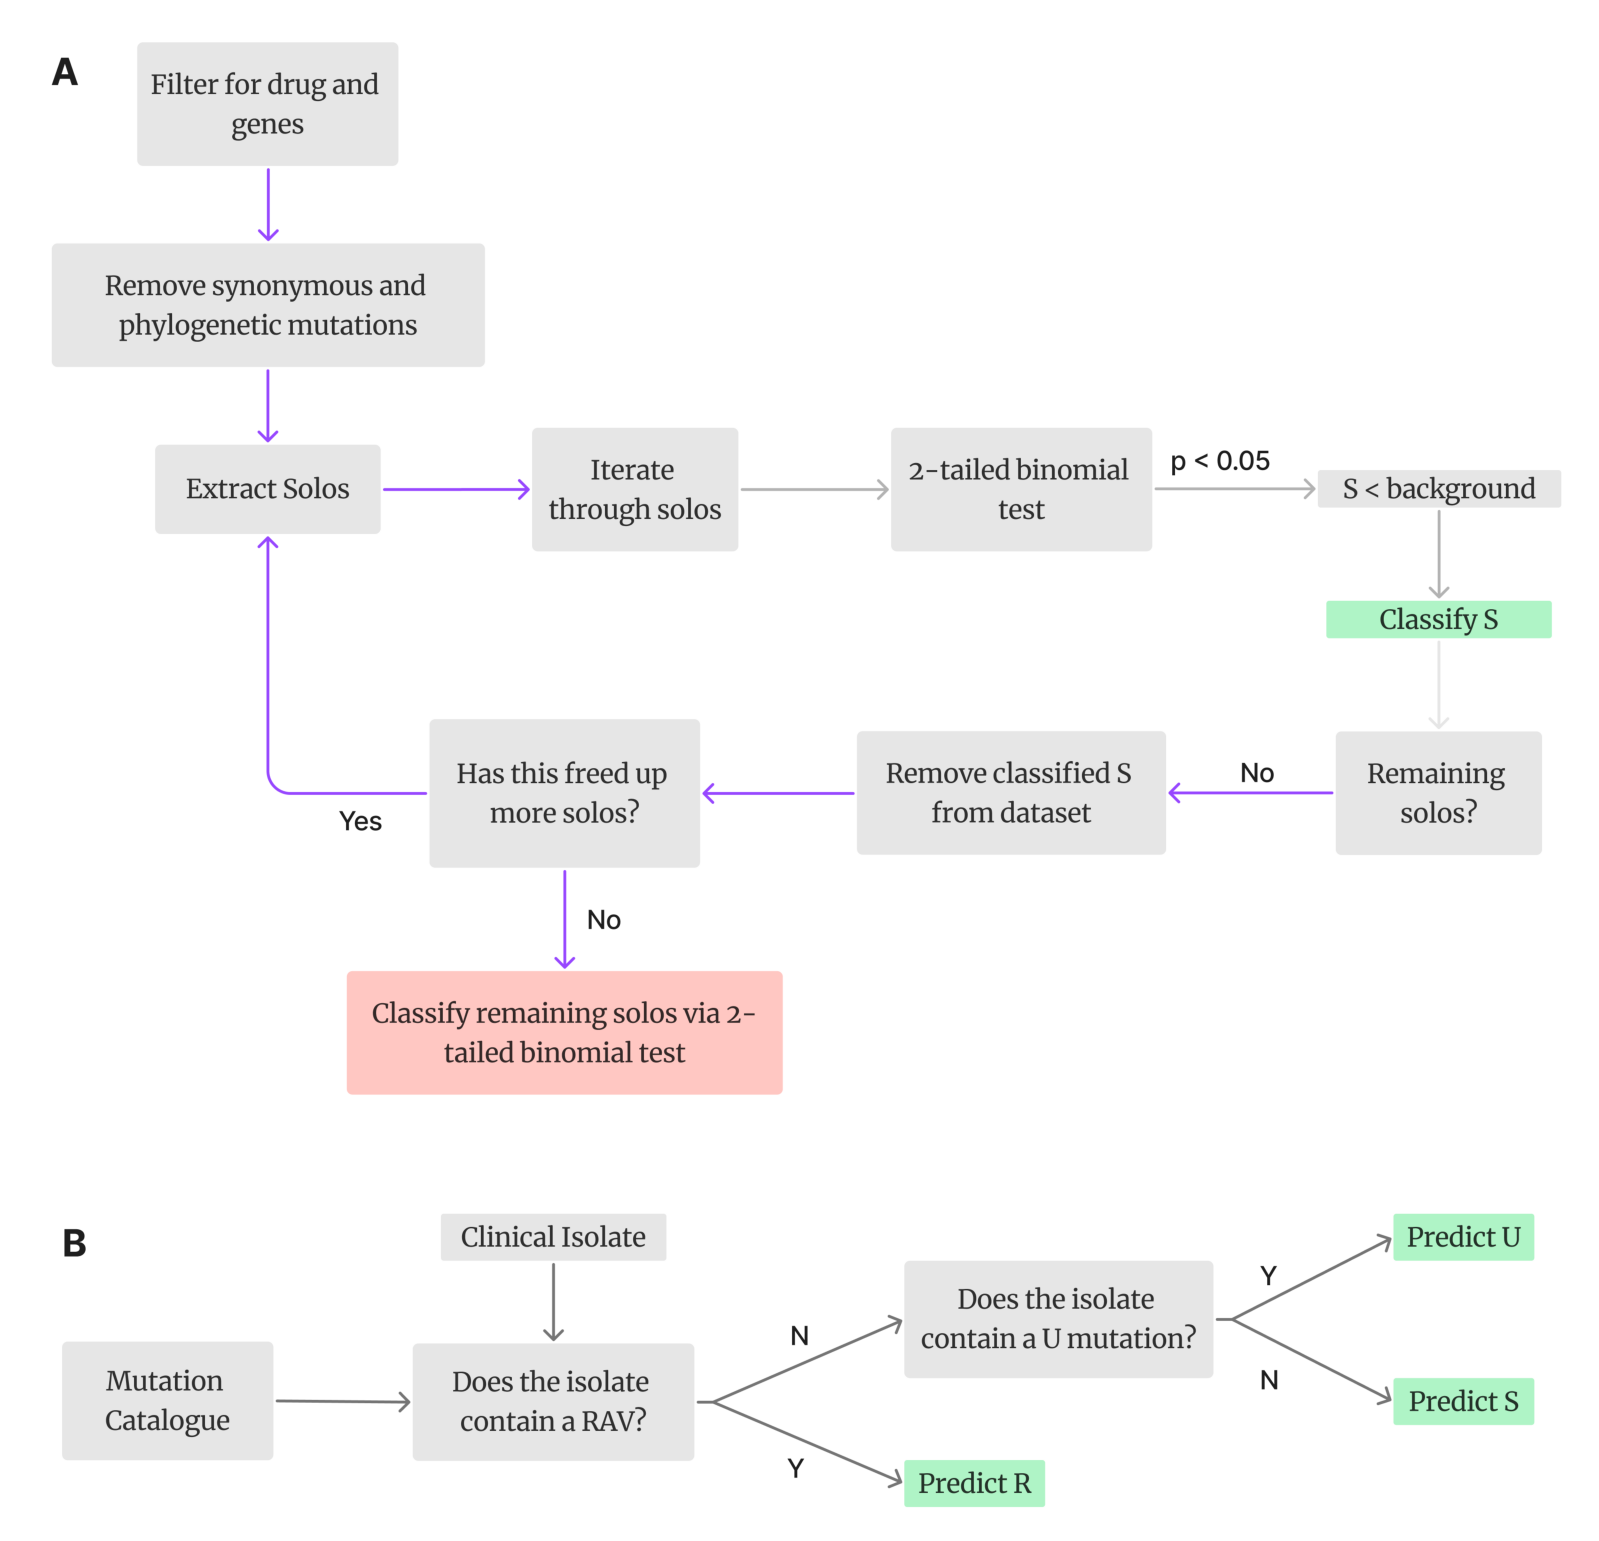

In [11]:
img = mpimg.imread('./imgs/fig-S1.png')
plt.figure(figsize=(8, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

We can build our catalogue on our entire dataset. 

We seed the catalogue with 2 neutral phylogenetic mutations in mmpL5; I948V and T794I [2]. These are extremeley high prevelance mutations and add noise.

In [12]:
#build the catalogue on the entire dataset.
catalogue = BinaryBuilder(samples=samples, mutations=cat_mutations, FRS=0.1).build(tails='two',  test='Binomial', background=0.1, strict_unlock=True)
#build a piezo-format catalogue dataframe
catalogue_df_all = catalogue.build_piezo("NC_000962.3", f"BDQ-2024.11", "1.1", "BDQ", piezo_wildcards, json_dumps=False)
catalogue_df_all

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,mmpL5@I948V,S,NaN,"{'proportion': 0.010521972354033423, 'confiden...",NaN
1,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,mmpL5@T794I,S,NaN,"{'proportion': 0.03565166569257744, 'confidenc...",NaN
2,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,mmpL5@D767N,S,NaN,"{'proportion': 0.005496281926931782, 'confiden...",NaN
3,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,mmpL5@F696L,S,NaN,"{'proportion': 0.0, 'confidence': (3.270053673...",NaN
4,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,mmpL5@Y300!,S,NaN,"{'proportion': 0.0, 'confidence': (1.687408794...",NaN
...,...,...,...,...,...,...,...,...,...,...,...
561,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,atpE@-*_indel,U,NaN,{'default_rule': 'True'},NaN
562,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,atpE@*_indel,U,NaN,{'default_rule': 'True'},NaN
563,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,atpE@-*?,U,NaN,{'default_rule': 'True'},NaN
564,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,atpE@*?,U,NaN,{'default_rule': 'True'},NaN


In [13]:
#filter out seeded and default rule rows for catalogue counts
catalogue_df_all = catalogue_df_all[~catalogue_df_all['EVIDENCE'].apply(lambda x: any(key in x for key in ['seeded', 'default_rule']))]

# Extract the gene names
catalogue_df_all["GENE"] = catalogue_df_all["MUTATION"].apply(lambda x: x.split("@")[0])

print ('Total classifications count:\n', catalogue_df_all.PREDICTION.value_counts())

Total classifications count:
 PREDICTION
U    459
R     70
S      7
Name: count, dtype: int64


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_31813/1260307116.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalogue_df_all["GENE"] = catalogue_df_all["MUTATION"].apply(lambda x: x.split("@")[0])


We have catalogued 70 resistance associated variants.

Most of our classifications are U's (or unknown) - these are primarily variants that are either observed in 1 resistant sample only (and zero susceptible) or display no evidence of resistance and exist in too few samples for a confident susceptible classification. A low background rate upweights resistance, and thus more data is needed to label a mutation susceptible.

In [32]:
catalogue_df_all[:3]

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER,GENE
0,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,mmpL5@I948V,S,NaN,"{'proportion': 0.010521972354033423, 'confiden...",NaN,mmpL5
1,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,mmpL5@T794I,S,NaN,"{'proportion': 0.03565166569257744, 'confidenc...",NaN,mmpL5
2,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,mmpL5@D767N,S,NaN,"{'proportion': 0.005496281926931782, 'confiden...",NaN,mmpL5


/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/tb-bdq-cat/protocols/utils.py:604: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GENE"] = df["MUTATION"].apply(lambda x: x.split("@")[0])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/tb-bdq-cat/protocols/utils.py:607: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby(["GENE", "PREDICTION"]).size().unstack(fill_value=0)


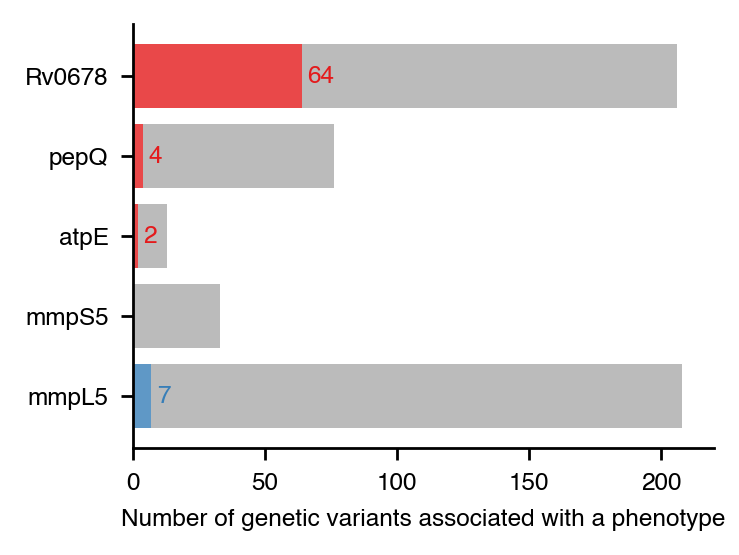

In [33]:
fig = utils.plot_catalogue_counts(catalogue_df_all, figsize=(3, 2.2))
fig.savefig('pdf/fig-cat1-gene-distribution.pdf', bbox_inches='tight')


Of note, there are zero resistant classifications in either mmpS5 or mmpL5 - this is not surprising given the completely absent proportions of resistance for sample containing only mmpL5 or mmpS5 variants (`supplement.ipynb`).

This is mirrored in [4, 7]

This does raise the question of whether these genes should be tier 1 candidates.... 

Becuase our algorithm relies on solos to make classifications, genes that are not resistance associated add noise. We should be able to remove mmpL5 and mmpS5 and build an equally, if not more, comprehensive catalogue:

In [34]:
#remove mmpL5 and mmpS5 from dataset.
cat_mutations = cat_mutations[~cat_mutations.GENE.isin(['mmpL5', 'mmpS5'])]
all = pd.merge(samples, mutations[~mutations.GENE.isin(['mmpL5', 'mmpS5'])], how='left', on='UNIQUEID')
all.FRS.fillna(1, inplace=True)

#read in wildcards without mmpL5 and mmpS5 for piezo
with open('./wildcards/bdq_wildcards_no_mmpL5.json') as f:
    piezo_wildcards = json.load(f)

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_14671/3055567171.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all.FRS.fillna(1, inplace=True)


In [35]:
#build the catalogue on the dataset without mmpL5 and mmpS5
catalogue = BinaryBuilder(samples=samples, mutations=cat_mutations, FRS=0.1).build(tails='two', test='Binomial', background=0.1, strict_unlock=True)

#build a piezo-format catalogue dataframe
catalogue_df = catalogue.build_piezo("NC_000962.3", f"BDQ-2024.11", "1.1", "BDQ", piezo_wildcards)
catalogue_df

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
313,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,Rv0678@*=,S,NaN,{'default_rule': 'True'},NaN
319,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,pepQ@*=,S,NaN,{'default_rule': 'True'},NaN
325,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,atpE@*=,S,NaN,{'default_rule': 'True'},NaN
5,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,Rv0678@192_ins_g,R,NaN,"{'proportion': 0.4230769230769231, 'confidence...",NaN
12,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,Rv0678@I67L,R,NaN,"{'proportion': 1.0, 'confidence': (0.342380227...",NaN
...,...,...,...,...,...,...,...,...,...,...,...
326,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,atpE@-*_indel,U,NaN,{'default_rule': 'True'},NaN
327,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,atpE@*_indel,U,NaN,{'default_rule': 'True'},NaN
328,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,atpE@-*?,U,NaN,{'default_rule': 'True'},NaN
329,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,atpE@*?,U,NaN,{'default_rule': 'True'},NaN


In [36]:
catalogue_df = catalogue_df[~catalogue_df['EVIDENCE'].apply(lambda x: any(key in x for key in ['seeded', 'default_rule']))]

print ('Total classifications count:\n', catalogue_df.PREDICTION.value_counts())

Total classifications count:
 PREDICTION
U    242
R     71
S      0
Name: count, dtype: int64


We have no catalogued no susceptible variants (as these were in mmpL5), and have catalogued an additional Rv0678 mutation - no real change, as mmpL5 and mmpS5 variants were neutral anyway:

/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/tb-bdq-cat/protocols/utils.py:604: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GENE"] = df["MUTATION"].apply(lambda x: x.split("@")[0])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/tb-bdq-cat/protocols/utils.py:607: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby(["GENE", "PREDICTION"]).size().unstack(fill_value=0)


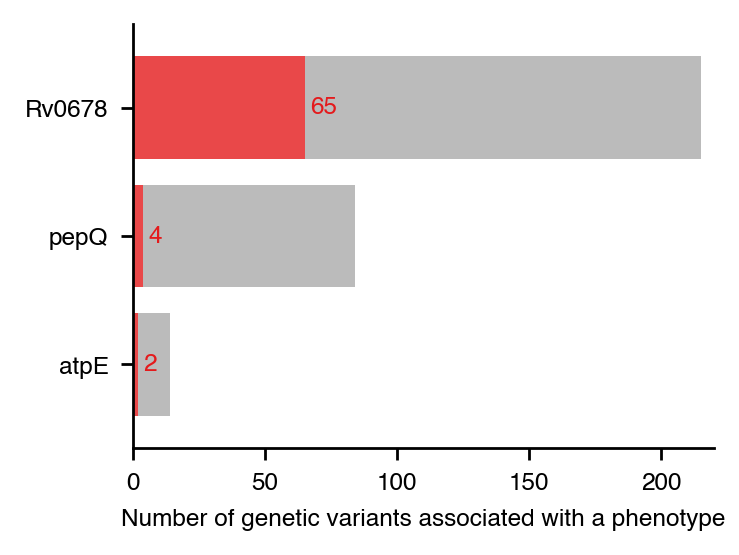

In [37]:
fig = utils.plot_catalogue_counts(catalogue_df, figsize=(3, 2.2))
fig.savefig('pdf/fig-cat2-gene-distribution.pdf', bbox_inches='tight')

From a user-standpoint, depending on the application a catalogue with no susceptible rows may be unhelpful. A 10% background rate, although sensible, is perhaps too conservative considering the limited statistical power at each position. In its current form the catalogue presents a list of resistance associated variants only.

However, the beauty of an algorithmic, user-friendly tool is that the background can simply be shifted and the catalogues rebuilt in 1 line of code. Raising it will allow susceptible variants to be captured.

Let's examine which positions in Rv0678 were catalogued resistant relative to all solo mutations:

                  Predicted R  Predicted U
GROUPED_POSITION                          
46                         74            2
47                        150            2
64                         97            1


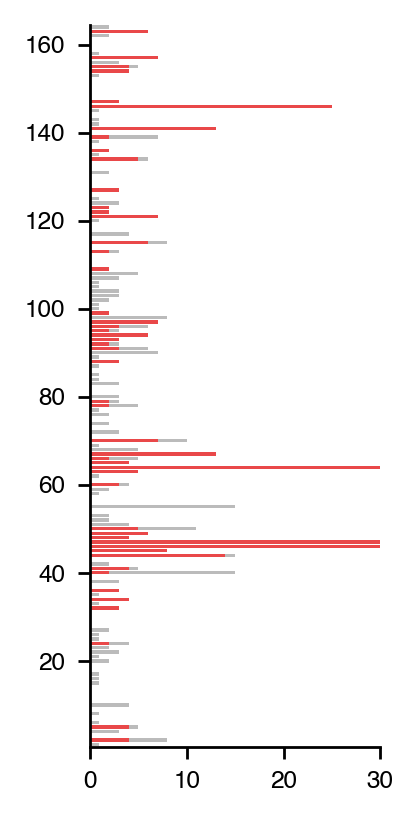

In [38]:
rv0678 = all[all.GENE == "Rv0678"].copy()

# uppdate GENE_POSITION based on NUCLEOTIDE_NUMBER for indels
rv0678["GENE_POSITION"] = rv0678.apply(
    lambda row: row["GENE_POSITION"] / 3 if pd.notna(row["NUCLEOTIDE_NUMBER"]) else row["GENE_POSITION"],
    axis=1
)
rv0678["GENE_POSITION"] = pd.to_numeric(rv0678["GENE_POSITION"], errors="coerce")
rv0678 = rv0678[rv0678["GENE_POSITION"] >= 0]

# group positions by pairs (0, 2, 4, etc.)
rv0678["GROUPED_POSITION"] = (rv0678["GENE_POSITION"] // 1) * 1

# create a complete range of grouped codon positions
all_grouped_positions = range(int(rv0678["GROUPED_POSITION"].min()), int(rv0678["GROUPED_POSITION"].max()) + 1, 1)
mutation_counts_grouped = rv0678["GROUPED_POSITION"].value_counts().reindex(all_grouped_positions, fill_value=0).sort_index()

rv0678['IS_R'] = [True if pheno == 'R' else False for pheno in rv0678.PHENOTYPE]
rv0678['CATALOGUED_R'] = [True if mut in catalogue_df[catalogue_df.PREDICTION=='R'].MUTATION.tolist() else False for mut in rv0678.MUTATION]
rv0678['CATALOGUED_U'] = [True if mut in catalogue_df[catalogue_df.PREDICTION=='U'].MUTATION.tolist() else False for mut in rv0678.MUTATION]

#idenitfy samples with solos
solos = all.groupby('UNIQUEID').filter(lambda x: len(x) == 1).UNIQUEID.tolist()
#filter for samples with solos only
rv0678_solos = rv0678[rv0678.UNIQUEID.isin(solos)]

mutation_counts_grouped = rv0678_solos["GROUPED_POSITION"].value_counts().reindex(all_grouped_positions, fill_value=0).sort_index()

#calculate R counts
r_counts_grouped = dict(
    rv0678_solos[rv0678_solos["IS_R"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)
#calculate catalogued R counts
catalogued_r_grouped = (
    rv0678_solos[rv0678_solos["CATALOGUED_R"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)
#calculate catalogued U counts
catalogued_u_grouped = (
    rv0678_solos[rv0678_solos["CATALOGUED_U"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

grouped_counts = { 'Predicted R':catalogued_r_grouped,  'Predicted U': catalogued_u_grouped,}


fig, axis = utils.plot_stacked_positions_vertical(grouped_counts, all_grouped_positions, colors=[ '#e41a1c', "#aaaaaa" ], line_counts=None, high_count_threshold=30, figsize=(1.5,3.75), bar_width=0.75, line_color='#6a3d9a', line_label='Observed R')
fig.savefig('pdf/fig-rv0678-codons-predicted.pdf',  transparent=True, bbox_inches='tight') 


The strings below are used to render images of the structure of Rv0678 with the codons associated with resistance and susceptibility picked out

In [22]:
# resistant codons
print('resid '+' '.join(str(i) for i in grouped_counts['Predicted R'][grouped_counts['Predicted R']>0].index))

# susceptible codons
print('resid '+' '.join(str(i) for i in grouped_counts['Predicted U'][grouped_counts['Predicted U']>0].index))


resid 2 5 24 32 34 36 40 41 44 45 46 47 48 49 50 60 63 64 65 66 67 70 78 79 88 91 92 93 94 95 96 97 99 109 113 115 121 122 123 127 134 136 139 141 146 147 154 155 157 163
resid 1 2 4 5 6 8 10 15 16 17 20 21 22 23 24 25 26 27 33 35 38 40 41 42 44 46 47 50 51 52 53 55 58 59 60 62 64 66 68 69 70 72 74 76 77 78 79 80 83 84 85 87 89 90 91 92 95 96 98 100 101 102 103 104 105 106 107 108 113 115 117 120 124 125 131 134 135 138 139 142 143 145 153 155 156 158 162 164


We have catalogued most high frequency positions associated with resistance, with only relatively low frequency sites remaining uncatalogued.

(obviously this plot has been coarse grained, so interpret with care)

Resistant variants are spread down the length of the gene.

Despite this high positional variance, a few mutations dominate; insertions at genomic positions 192, 141, and 138. These all exist within the DNA binding site of Rv0678:


In [23]:
cat_counts = catalogue_df.copy()


# Extract R, S, and total counts
cat_counts['R'] = cat_counts['EVIDENCE'].apply(lambda x: x['contingency'][0][0] if x else 0)
cat_counts['S'] = cat_counts['EVIDENCE'].apply(lambda x: x['contingency'][0][1] if x else 0)
cat_counts['total_count'] = cat_counts['R'] + cat_counts['S']

# Filter rows with total counts above 5

print ('The number of solos in resistant and susceptible samples used to classify each mutation in the catalogue (n > 5):')

cat_counts[cat_counts.total_count>5][['MUTATION', 'R', 'S', 'total_count']]

The number of solos in resistant and susceptible samples used to classify each mutation in the catalogue (n > 5):


,MUTATION,R,S,total_count
5,Rv0678@192_ins_g,33,45,78
45,Rv0678@141_ins_c,124,26,150
48,Rv0678@132_ins_gt,12,2,14
53,Rv0678@138_ins_g,35,12,47
60,Rv0678@491_ins_cg,5,1,6
76,Rv0678@G121R,6,1,7
107,Rv0678@C46R,5,1,6
175,Rv0678@M146T,11,14,25
178,Rv0678@193_del_g,10,6,16
190,Rv0678@I67S,11,0,11


In [24]:
total = len(rv0678_solos[(rv0678_solos.CATALOGUED_R)])
num_in_binding_region = len(rv0678_solos[(rv0678_solos.CATALOGUED_R) & (rv0678_solos.GROUPED_POSITION >= 36) & (rv0678_solos.GROUPED_POSITION <= 99)])
num_in_a2a3 = len(rv0678_solos[(rv0678_solos.CATALOGUED_R)&(rv0678_solos.GROUPED_POSITION >= 36) & (rv0678_solos.GROUPED_POSITION<=62)])
num_in_dimer1 = len(rv0678_solos[(rv0678_solos.CATALOGUED_R)&(rv0678_solos.GROUPED_POSITION >= 16) & (rv0678_solos.GROUPED_POSITION<=33)])
num_in_dimer2 = len(rv0678_solos[(rv0678_solos.CATALOGUED_R)&(rv0678_solos.GROUPED_POSITION >= 100) & (rv0678_solos.GROUPED_POSITION<=160)])
num_138_fs = len(rv0678_solos[rv0678_solos.MUTATION=='Rv0678@138_ins_g'])
num_141_fs = len(rv0678_solos[rv0678_solos.MUTATION=='Rv0678@141_ins_c'])
num_192_fs = len(rv0678_solos[rv0678_solos.MUTATION=='Rv0678@192_ins_g'])


print ('Number of catalogued solos observed in Rv0678:', total)

print ('\nFraction of catalogued solos observed in binding region:', str(num_in_binding_region), ':', num_in_binding_region/total)
print ('Fraction of catalogued solos observed in a2-a3 helix:', str(num_in_a2a3), ':',num_in_a2a3/total)

print ('Fraction of catalogued solos that are 138_ins_g:', num_138_fs, ':', num_138_fs/total)
print ('Fraction of catalogued solos that are 141_ins_c:', num_141_fs, ':', num_141_fs/total)
print ('Fraction of catalogued solos that are 192_ins_g:', num_192_fs, ':', num_192_fs/total)

print ('\nFraction of catalogued solos observed in the first dimerisation domain (16-33)', str(num_in_dimer1), ':', num_in_dimer1/total)
print ('Fraction of catalogued solos observed in the second dimerisation domain (100-160)', str(num_in_dimer2),':', num_in_dimer2/total)




Number of catalogued solos observed in Rv0678: 548

Fraction of catalogued solos observed in binding region: 436 : 0.7956204379562044
Fraction of catalogued solos observed in a2-a3 helix: 273 : 0.4981751824817518
Fraction of catalogued solos that are 138_ins_g: 46 : 0.08394160583941605
Fraction of catalogued solos that are 141_ins_c: 150 : 0.2737226277372263
Fraction of catalogued solos that are 192_ins_g: 78 : 0.14233576642335766

Fraction of catalogued solos observed in the first dimerisation domain (16-33) 5 : 0.009124087591240875
Fraction of catalogued solos observed in the second dimerisation domain (100-160) 89 : 0.1624087591240876


In [25]:
rv0678_solos = rv0678_solos.copy(deep=True)
# Add IS_STOP column
rv0678_solos['IS_STOP'] = rv0678_solos['MUTATION'].str.endswith('!')

# Add IS_INDEL column
rv0678_solos["IS_INDEL"] = rv0678_solos["INDEL_LENGTH"].notna()

point_counts_grouped = (
    rv0678_solos[(~rv0678_solos["IS_INDEL"])&(~rv0678_solos['IS_STOP'])]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

# Calculate INDEL counts
indel_counts_grouped = (
    rv0678_solos[rv0678_solos["IS_INDEL"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

# Calculate STOP counts
stop_counts_grouped = (
    rv0678_solos[rv0678_solos["IS_STOP"]]["GROUPED_POSITION"]
    .value_counts()
    .reindex(all_grouped_positions, fill_value=0)
    .sort_index()
)

grouped_counts = {'Catalogued Stops':stop_counts_grouped, 'Catalogued Indel':indel_counts_grouped, 'Catalogued SNPs': point_counts_grouped, }

fig, axis = utils.plot_stacked_positions(grouped_counts, all_grouped_positions, colors=['#fc8d62',  "#8da0cb", '#66c2a5', ], high_count_threshold=30, figsize=(20, 8), bar_width=0.75)
fig.savefig('pdf/fig-rv0678-codons-catalogued.pdf',  transparent=True) 
plt.close()

A huge proportion of catalogued mutations are indels, spread across the gene. Premature stop codons are relativley uncommon:

In [26]:
# Identify solos
solos = all.groupby('UNIQUEID').filter(lambda x: len(x) == 1).UNIQUEID.tolist()
all_R_solos = all[(all.UNIQUEID.isin(solos)) & (all.PHENOTYPE == 'R')]

#identify mutations catalogued R
catalogued_R = catalogue_df[catalogue_df.PREDICTION == 'R'].MUTATION.tolist()

# Identify indels that are 1 or 2 bases long or are stop codons - ie loss of functions
R_indel_lof_criteria = all_R_solos[(all_R_solos.MUTATION.isin(catalogued_R)) & 
                                (all_R_solos.INDEL_LENGTH.isin([1, 2]))]
R_stop_lof_criteria = all_R_solos[(all_R_solos.MUTATION.isin(catalogued_R)) & 
                                (all_R_solos['MUTATION'].str.endswith('!'))]

indel_counts = len(R_indel_lof_criteria)
stop_counts = len(R_stop_lof_criteria)
total_R_solos = len(all_R_solos)

# Function to check for 1 or 2 base indels in mutation strings
def is_lof_indel(mutation):
    if 'ins_' in mutation or 'del_' in mutation:
        parts = mutation.split('_')
        if len(parts) == 3:
            return len(parts[2]) in [1, 2]
    return False

# Catalogued mutations in the dataset
total_rows = len(cat_counts[cat_counts.PREDICTION.isin(['R', 'S'])])
indel_cat_counts = len(cat_counts[(cat_counts.PREDICTION.isin(['R', 'S'])) & 
                                (cat_counts['MUTATION'].apply(is_lof_indel))])
stop_cat_counts = len(cat_counts[(cat_counts['MUTATION'].str.endswith('!')) & 
                               (cat_counts.PREDICTION.isin(['R', 'S']))])

# Print results
print('Fraction of catalogue rows that are frameshift indels:', indel_cat_counts, ':', indel_cat_counts / total_rows)
print('Fraction of catalogue rows that are stops:', stop_cat_counts, ':', stop_cat_counts / total_rows)

print ('\nTotal number of solos observed in resistant samples:', total_R_solos)
print('Fraction of resistant solos that are catalogued frameshift indels:', indel_counts, ':', indel_counts / total_R_solos)
print('Fraction of resistant solos that are catalogued stops:', stop_counts, ':', stop_counts / total_R_solos)


Fraction of catalogue rows that are frameshift indels: 26 : 0.36619718309859156
Fraction of catalogue rows that are stops: 5 : 0.07042253521126761

Total number of solos observed in resistant samples: 661
Fraction of resistant solos that are catalogued frameshift indels: 275 : 0.41603630862329805
Fraction of resistant solos that are catalogued stops: 14 : 0.02118003025718608


This does raise the question of whether an aggregate rule should be applied, such as in the WHOv2 catalogue, where pepQ and Rv0678 indels and premature stop codons are treated as single, resistant entries in the catalogue. 

If we had sufficient phenotype homogeneity and a strong mean penetration, we could probably do the same:



In [27]:
#extract all samples with lof solos
all_lof_solos = all[(all.UNIQUEID.isin(solos))&(all.INDEL_LENGTH.isin([1, 2])|all_R_solos['MUTATION'].str.endswith('!'))]
R_lof_solos = all_lof_solos[all_lof_solos.PHENOTYPE=='R']

all_catalogued_lof_solos = all_lof_solos[all_lof_solos.MUTATION.isin(catalogued_R)]
all_R_catalogued_lof_solos = all_catalogued_lof_solos[all_catalogued_lof_solos.PHENOTYPE=='R']

print ('Number of samples with lof solos:', len(all_lof_solos))
print ('Fraction of samples with lof solos that are resistant:', len(R_lof_solos),':', len(R_lof_solos)/len(all_lof_solos))

print ('\nNumber of samples with catalogued lof solos:', len(all_catalogued_lof_solos))
print ('Fraction of samples with catalogued lof solos that are resistant:', len(all_R_catalogued_lof_solos), ':', len(all_R_catalogued_lof_solos)/len(all_catalogued_lof_solos))


Number of samples with lof solos: 409
Fraction of samples with lof solos that are resistant: 308 : 0.7530562347188264

Number of samples with catalogued lof solos: 382
Fraction of samples with catalogued lof solos that are resistant: 289 : 0.756544502617801


This would bring our very major errors down, but at the cost of additional false positives (due to heteroresistance). Looking at the proportions of resistance in samples that (only) contain loss of function mutations.

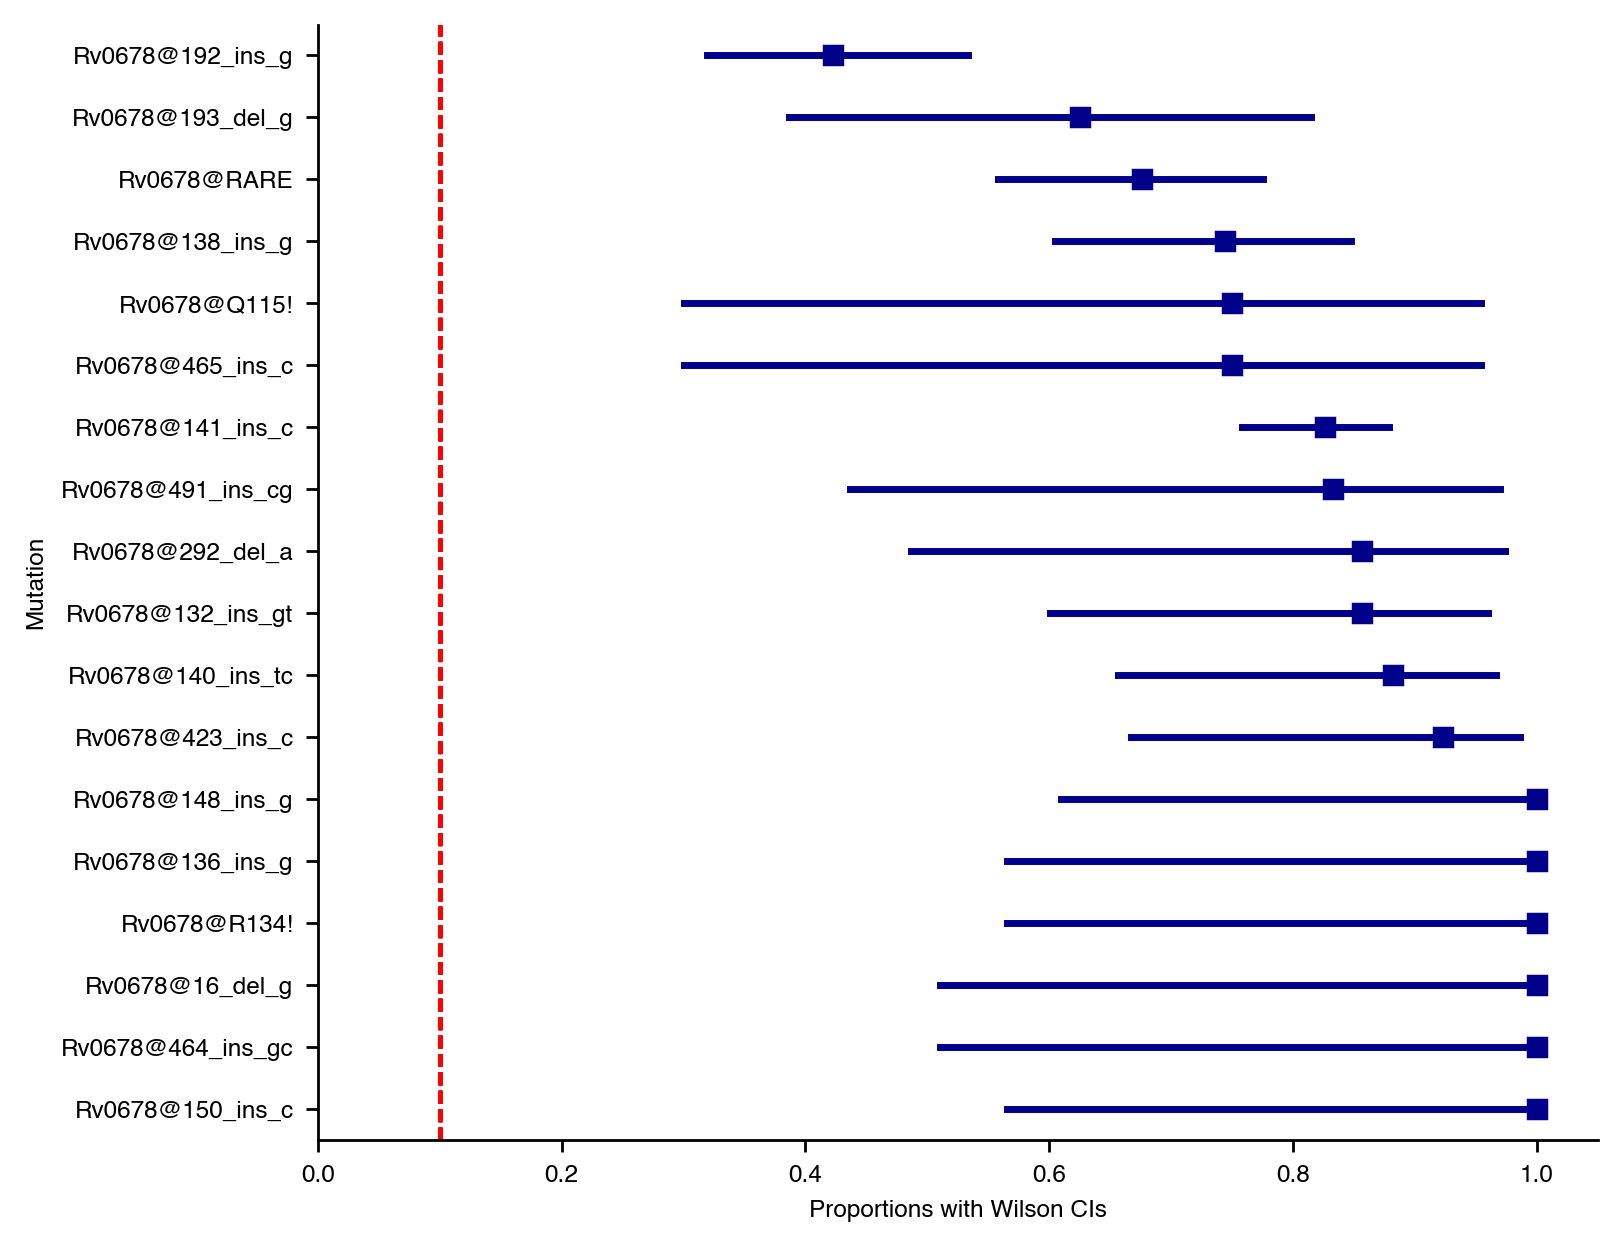

In [28]:
cat_counts['IS_STOP'] = cat_counts['MUTATION'].str.endswith('!')
cat_counts["IS_INDEL"] = cat_counts["MUTATION"].str.contains(r'ins_|del_')

lof_counts = cat_counts[cat_counts.IS_STOP | cat_counts.IS_INDEL]

# Pool rows with total_count < 2
to_pool_df = lof_counts[lof_counts['total_count'] < 3]
remaining_df = lof_counts[lof_counts['total_count'] >= 4]

# Aggregate the pooled rows
pooled_row = to_pool_df.agg({
    'R': 'sum',
    'S': 'sum',
    'total_count': 'sum'
}).to_frame().T

# Set the MUTATION value for the pooled row
pooled_row.loc[:, 'MUTATION'] = 'Rv0678@RARE'

# Concatenate the remaining rows with the pooled row
high_freq = pd.concat([remaining_df, pooled_row], ignore_index=True)

#re-calculate proportion and confidence interval for each row (could just pull from evidence, but the rare row will screw it up)
high_freq[['Proportion', 'lower_bound', 'upper_bound']] = high_freq.apply(lambda row: utils.wilson(row['R'], row['S']), axis=1)

high_freq = high_freq.sort_values(by=['Proportion'], ascending=False)

utils.plot_catalogue_counts_from_df(high_freq, figsize=(6.5, 5), order=False, background=0.1)

Most high frequency loss of function mutations have high positive effect sizes - despite heroresistance, the probability of resistance for each mutation is sufficiently high to justify aggregating all loss of function mutations under an expert rule.

However, given that a fair number of low frequency mutations are still susceptible (even if statsitical power is low), and the fact we are yet to conclusively map out ressitance associated variants (even breakpoints are being called into question), remaining on the safe side and avoiding applying expert rules is probably more sensible.

However, `catomatic` does allow for the addition of expert rules, supporting single mutation additions or ammendmants as well as aggregate rules. Rules can eithe replace all mutations that fall under the rule, or are added in addition to - the strength of the latter appraoch is catalogued mutations retain their phenotype, but a rule exists to capture unseen mutations and assign an assumed phenotype.

Replacing relevant rows with the rule would mirror the WHO's approach:

In [25]:
#Build a new catalogue (same as above - just don't want to modify the catalogue used elsewhere in the notebook)
catalogue_lof = BinaryBuilder(samples=samples, mutations=cat_mutations, FRS=0.1).build(tails='two', test='Binomial', background=0.1, strict_unlock=True)
#add expert lof rules for indels and preamture stop codons to the catalogue, using replacement
catalogue_lof.update({ 'Rv0678@*_indel':'R','Rv0678@*!':'R', 'pepQ@*_indel':'R', 'pepQ@*!':'R', 'atpE@*_indel':'R', 'atpE@*!':'R',}, replace=True, wildcards='./wildcards/bdq_wildcards_no_mmpL5.json')

#load in wildcards that do not contain a row for indel rules (otherwise will overwrite)
with open('./wildcards/bdq_wildcards_lof_replace.json') as f:
    piezo_wildcards_lof = json.load(f)

catalogue_lof_df = catalogue_lof.build_piezo("NC_000962.3", f"BDQ-2024.11", "1.1", "BDQ", piezo_wildcards_lof)
#6 loss of function rows have been added
catalogue_lof_df[catalogue_lof_df.PREDICTION=='R'][-6:]

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
233,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,Rv0678@*_indel,R,NaN,{},NaN
234,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,Rv0678@*!,R,NaN,{},NaN
235,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,pepQ@*_indel,R,NaN,{},NaN
236,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,pepQ@*!,R,NaN,{},NaN
237,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,atpE@*_indel,R,NaN,{},NaN
238,NC_000962.3,BDQ-2024.11,1.1,GARC1,RUS,BDQ,atpE@*!,R,NaN,{},NaN


However, we strongly advocate for entirely algorithmic approaches to ensure reproducibility, and would typically not advise adding or adapting rows.


### vs WHOv2

Aside from the undelying algorithm, the main differences between the  the WHOv2 catalogue and ours:
- WHO have constructed at a higher FRS (discussed later)
- WHO have used aggregate rules for loss of function mutations in Rv0678 and pepQ
- WHO have tried to catalogue mmpL5 and mmpS5 (although nothing was added)

How does this translate to difference in contents?

In [28]:
#read in the parsed WHO catalogue, and clean (U's are as meangingless as non-catalogued, so can discard)
who_path = './catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv'
who = pd.read_csv(who_path)
who_df = who[(who.DRUG=='BDQ')&(who.PREDICTION.isin(['R', 'S']))].copy()
who_df['PREDICTION_VALUES'] = 'RS'

# Convert evidence entries to dicts, and remove wildcard rows
evidence = who_df['EVIDENCE'].apply(utils.str_to_dict)
#remove wildcard rows
who_df = who_df[
    ~evidence.apply(lambda x: 'default_rule' in x) 
]

print ('Number of variants classified Resistant or Susceptible in the WHOv2 catalogue:\n', who_df[~who_df['MUTATION'].str.contains('*', regex=False)].PREDICTION.value_counts())

print ('\nNumber of rules classified Resistant or Susceptible in the WHOv2 catalogue:\n', who_df[who_df['MUTATION'].str.contains('*', regex=False)].PREDICTION.value_counts())


Number of variants classified Resistant or Susceptible in the WHOv2 catalogue:
 PREDICTION
R    34
S     2
Name: count, dtype: int64

Number of rules classified Resistant or Susceptible in the WHOv2 catalogue:
 PREDICTION
R    4
Name: count, dtype: int64


Note the actual number of explicitly catalogues RAVs is actually 19 - piezo has parsed premature stop codons seperately (ie not under the WHO's rule), which adds 15 RAVs to the count above

In [29]:
who_df_no_aggr= who_df[~who_df['MUTATION'].str.contains(r'[*?=]', regex=True)]
who_df_no_aggr.to_csv("./catalogues/temp/WHOv2_adapted.csv")
who_cat_no_aggr = piezo.ResistanceCatalogue("./catalogues/temp/WHOv2_adapted.csv")
who_cat = piezo.ResistanceCatalogue(who_path)

matched, matched_no_aggr = {"shared": [], "not_shared": []}, {"shared": [], "not_shared": []}
#how many non-U variants are shared between our catalogue and WHOv2
for var in catalogue_df[catalogue_df.PREDICTION!='U'].MUTATION:
    try:
        prediction = who_cat.predict(var)['BDQ']
        (matched["shared"] if prediction in ["R", "S"] else matched["not_shared"]).append(var)
    except ValueError:
        matched["not_shared"].append(var)
    try:
        prediction_no_aggr = who_cat_no_aggr.predict(var)["BDQ"]
        (matched_no_aggr["shared"] if prediction_no_aggr in ["R", "S"] else matched_no_aggr["not_shared"]).append(var)
    except:
        matched_no_aggr["not_shared"].append(var)

print ('Number of shared variants across catalogues, including aggregates:', len(matched['shared']))
print ('Number of shared variants across catalogues,excluding aggregates:', len(matched_no_aggr['shared']))



Number of shared variants across catalogues, including aggregates: 41
Number of shared variants across catalogues,excluding aggregates: 14


In [30]:
#which variants only exist in WHOv2 (need to remove aggregates, as these could constitute any number of variants
wildcard_chars = {'*', '?', '='}
who_only = who_df[~who_df['MUTATION'].isin(matched_no_aggr['shared'])]['MUTATION'].unique()
who_only = [i for i in who_only if not any(c in i for c in wildcard_chars)]

print ('Number of mutations in WHOv2 only (not counting aggregates or mmpL5/mmpS5):', len(who_only))

Number of mutations in WHOv2 only (not counting aggregates or mmpL5/mmpS5): 20


In [31]:
print ('number of these variants that are U in our catalogue:', len(catalogue_df[catalogue_df.MUTATION.isin(who_only)]))
print ('number of these variants that were not encountered:', len(who_only)- len(catalogue_df[catalogue_df.MUTATION.isin(who_only)]))

number of these variants that are U in our catalogue: 10
number of these variants that were not encountered: 10


In [32]:
mmm_only = catalogue_df[(~catalogue_df['MUTATION'].isin(matched['shared']))&(catalogue_df.PREDICTION!='U')]['MUTATION'].unique()
mmm_only = [i for i in mmm_only if not any(c in i for c in wildcard_chars)]

mmm_only_no_aggr = catalogue_df[(~catalogue_df['MUTATION'].isin(matched_no_aggr['shared']))&(catalogue_df.PREDICTION!='U')]['MUTATION'].unique()
mmm_only_no_aggr = [i for i in mmm_only_no_aggr if not any(c in i for c in wildcard_chars)]

print ('Number of mutations in our catalogue only (including WHO aggregates):', len(mmm_only))
print ('Number of mutations in our catalogue only (excluding WHO aggregates):', len(mmm_only_no_aggr))


Number of mutations in our catalogue only (including WHO aggregates): 30
Number of mutations in our catalogue only (excluding WHO aggregates): 57


Including aggregate rules:


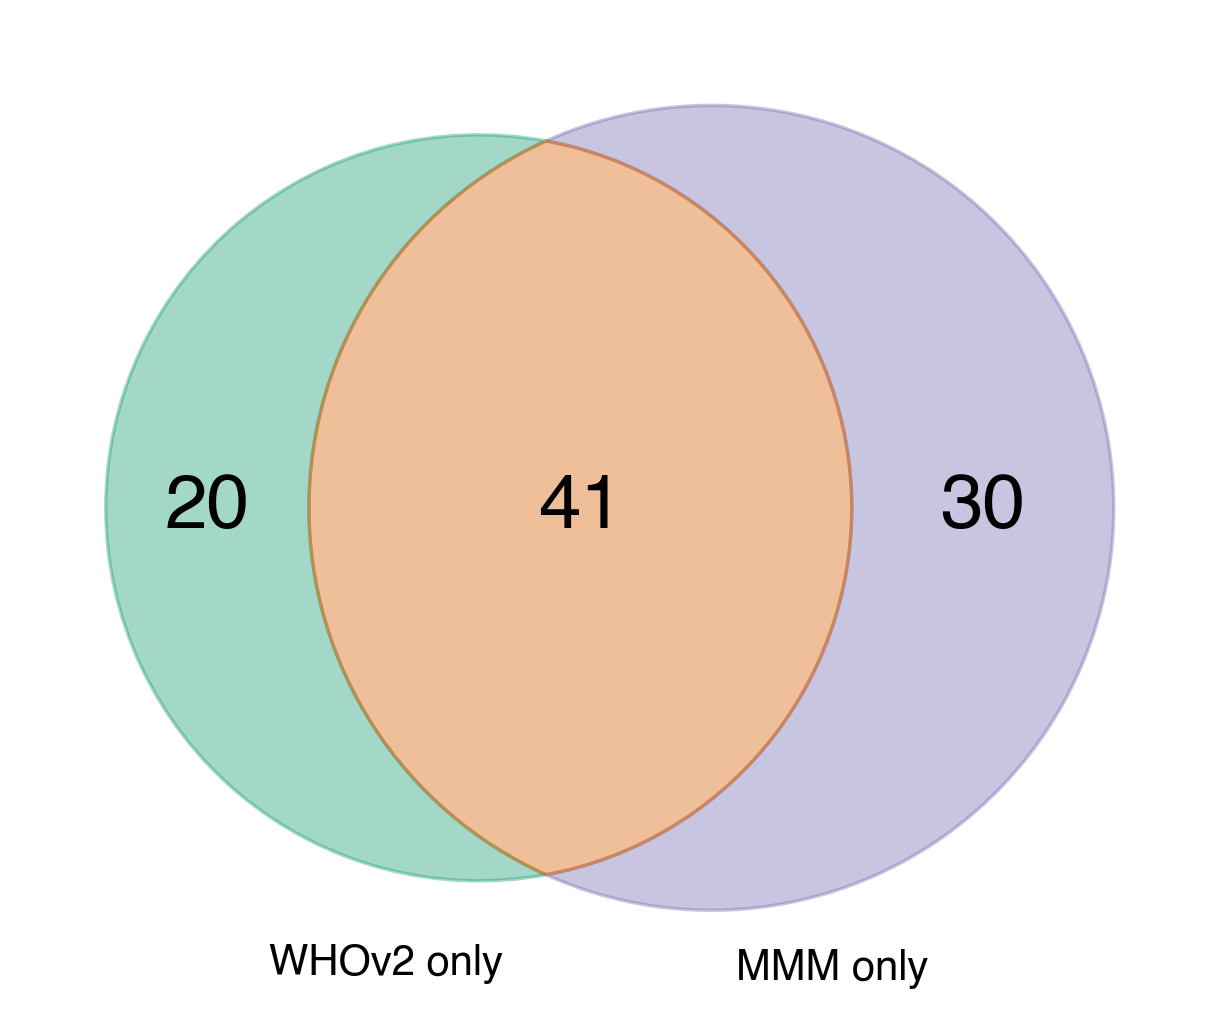

In [33]:
print ('Including aggregate rules:')
utils.plot_tricolour_venn((len(who_only), len(mmm_only), len(matched['shared'])), ['WHOv2 only', 'MMM only'], y_offsets=(-0.03, 0))

Excluding aggregate rules:


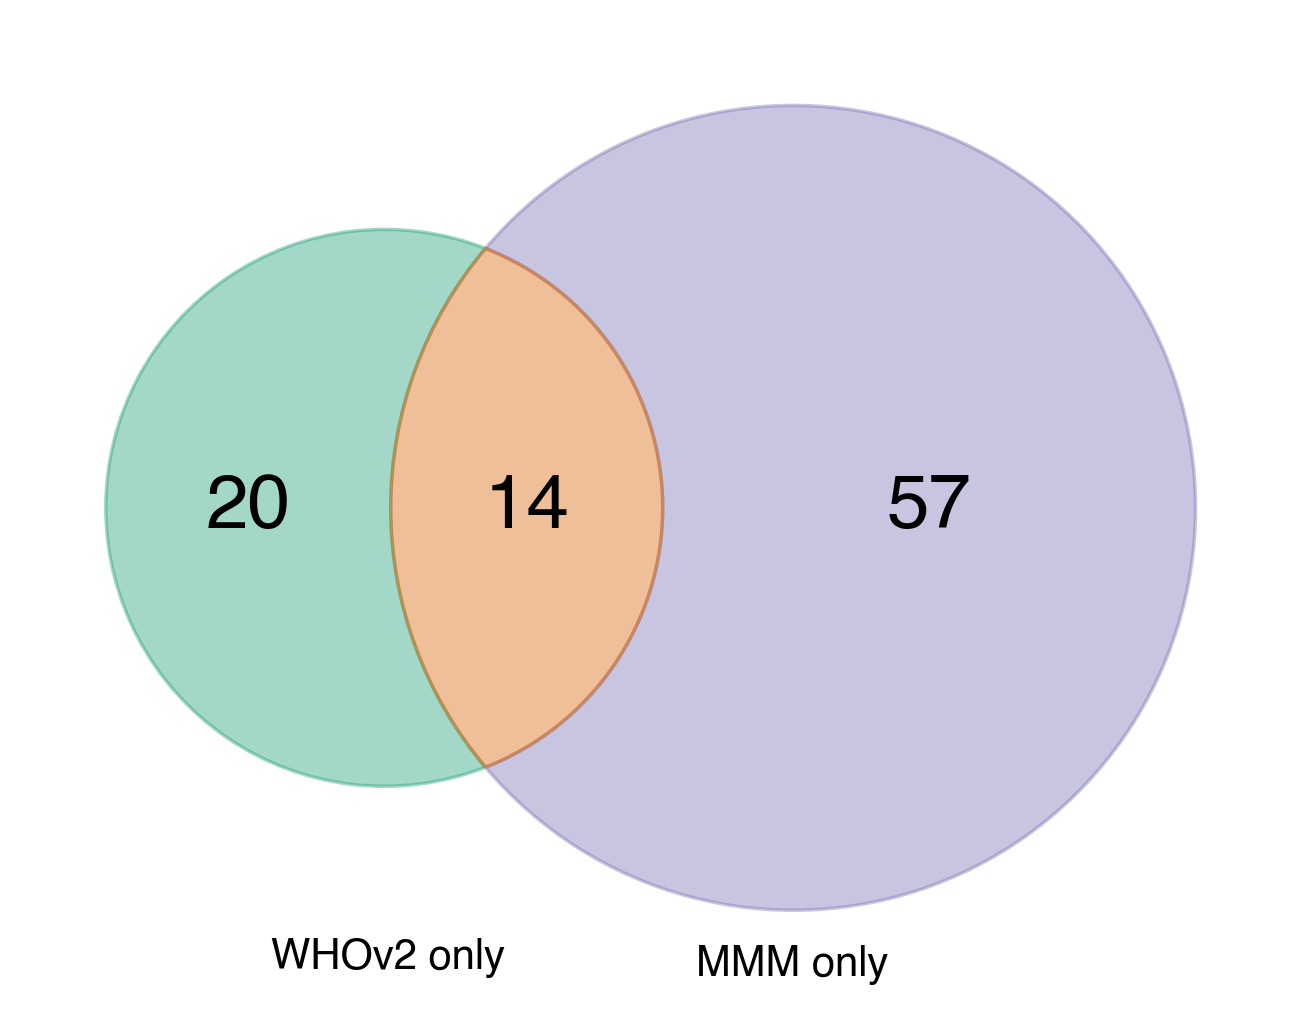

In [34]:
print ('Excluding aggregate rules:')
utils.plot_tricolour_venn((len(who_only), len(mmm_only_no_aggr), len(matched_no_aggr['shared'])), ['WHOv2 only', 'MMM only'], x_offsets=(0.15, -0.12), y_offsets=(-0.145, 0))


Of course there are also no phenotype disagreements between mutations that are shared across catalogues, as both only contains resistant variants (at this stage).

# Catalogue Performance

To test the performance of our catalogue, we can use Piezo to make sample-level predictions, using a supplied catalogue as input.

Ideally, we would validate on an indendent test dataset. However, we don't have enough data to form another set, so like the WHOv2 we must make predictions on the trianing set, and just achknowledge this is probably an over estimate.

If we follow the WHO prediction protocol, whereby samples that contain catalogued Resistant mutations (Group 1 and 2) are resistant and all other samples are susceptible, and exlcuding mmpL5 and mmpS5, we achieve a maximum sensitivity of:

[[  607   259]
 [  172 10829]]
Catalogue coverage of isolates: 1.0
Sensitivity: 0.7009237875288684
Specificity: 0.9843650577220253


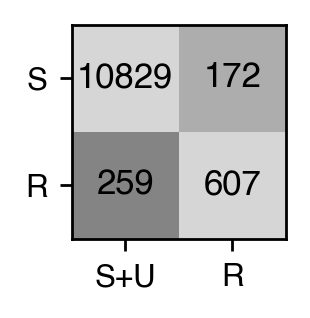

In [35]:
#export catalogue to piezo compatible csv
catalogue.to_piezo("NC_000962.3", f"BDQ-2024.11", "1.1", "BDQ", piezo_wildcards, outfile='./catalogues/manuscript/catomatic_1.csv')

#test catalogue on entire dataset using piezo
cm, _cov, _sens_75, _spec_75, _FN_ids, _FP_ids = piezo_predict(all, f"./catalogues/manuscript/catomatic_1.csv", "BDQ", Print=True, U_to_S=True)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

utils.plot_truthtables(df_cm, U_to_S=True, colors=["#666666", "#cccccc", "#999999", "#cccccc"])

Performance is decent, relative to the WHO catalogues:



WHOV2 tested on our entire dataset:
[[  589   277]
 [  201 10800]]
Catalogue coverage of isolates: 1.0
Sensitivity: 0.6801385681293303
Specificity: 0.981728933733297


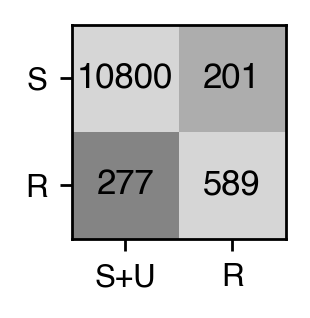

In [36]:
#WHO catalogue tested on our entire dataset
print ('WHOV2 tested on our entire dataset:')

cm_who, _cov, _who_sens, _who_spec, _FN_ids, _FP_ids = piezo_predict(all, "./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv", "BDQ", Print=True, U_to_S=True)

df_cm_who = pd.DataFrame(cm_who, index=["R", "S"], columns=["R", "S"])

utils.plot_truthtables(df_cm_who, U_to_S=True, colors=["#666666", "#cccccc", "#999999", "#cccccc"])

Are the sensitivities and specifcies significantly different? could use mcnemar test due to paired tests (same test set), bur for clarity just stick to chi squared


In [37]:
tp1, fn1 = df_cm.loc['R', 'R'], df_cm.loc['R', 'S']
fp1, tn1 = df_cm.loc['S', 'R'], df_cm.loc['S', 'S']
tp2, fn2 = df_cm_who.loc['R', 'R'], df_cm_who.loc['R', 'S']
fp2, tn2 = df_cm_who.loc['S', 'R'], df_cm_who.loc['S', 'S']

sensitivity_table = [[tp1, fn1],[tp2, fn2]]
specificity_table = [[tn1, fp1],[tn2, fp2]]

result_sensitivity = chi2_contingency(sensitivity_table)
print(f"Sensitivity p-value: {result_sensitivity.pvalue}")
result_specificity = chi2_contingency(specificity_table)
print(f"Specificity p-value: {result_specificity.pvalue}")


Sensitivity p-value: 0.37689111344035453
Specificity p-value: 0.14367746891549338


However, we argue assuming samples that contain unkown or unclassified mutations are susceptible, is clinically dangerous - there is no evidence this is the case.

Therefore, we will use a ternary prediction system (similar to the ternary classification system), whereby samples that contain an unseen or unclassified mutation are reported seperately as 'unkown' or 'unclassified'.

We can then introduce an additional performance metric, 'sample coverage', which represents the fraction of samples for which R or S predictions could be made:

[[  607   135   124]
 [  172 10370   459]]
Catalogue coverage of isolates: 0.9508721665121767
Sensitivity: 0.8180592991913747
Specificity: 0.9836843103775375


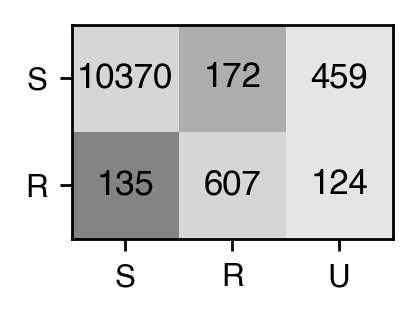

In [38]:
#export catalogue to piezo compatible csv (catalogue is actually the same as catomatic 1, just evaluated differently)
catalogue.to_piezo("NC_000962.3", f"BDQ-2024.11", "1.1", "BDQ", piezo_wildcards, outfile='./catalogues/manuscript/catomatic_2.csv')

#test catalogue on entire dataset using piezo
cm, _cov, _sens_75, _spec_75, _FN_ids, _FP_ids = piezo_predict(all, f"./catalogues/manuscript/catomatic_2.csv", "BDQ", Print=True, U_to_S=False)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", 'U'])

utils.plot_truthtables(df_cm, U_to_S=False, colors=["#666666", "#cccccc", "#999999", "#cccccc","#cccccc","#cccccc" ])

We accordingly achieve 81.8% sensitivity and 98.4% specificiy for for 95.1% of samples.

Our very major error has reduced from 29.9% to 18.2% as those samples containg low confidence susceptible variants are excluded.

The 172 false positives primarily derive from samples containing heteroresistant, high-frequency insertions or deletions (discussed above and in the `supplement.ipynb`):

In [39]:
print ('The number of False Positive predictions that contain each of the mutations found in all False positives:')
pd.DataFrame(all[all.UNIQUEID.isin(_FP_ids)].MUTATION.value_counts()).rename(columns={'MUTATION':'Samples'})

The number of False Positive predictions that contain each of the mutations found in all False positives:


,count
MUTATION,
Rv0678@192_ins_g,55
Rv0678@141_ins_c,47
Rv0678@138_ins_g,26
Rv0678@M146T,14
Rv0678@c-11a,10
...,...
pepQ@A152A,1
pepQ@A153A,1
pepQ@T155G,1


However, the 135 false negative predictions are more interesting:

In [40]:
print ('The number of False Negative predictions that contain each of the mutations found in all false negative:')
pd.DataFrame(all[all.UNIQUEID.isin(_FN_ids)].MUTATION.value_counts()).rename(columns={'MUTATION':'Samples'})

The number of False Negative predictions that contain each of the mutations found in all false negative:


,count
MUTATION,


All false negative predictions contain wild type candidate genes, aside from 4 samples that each contain a non-phylogenetic and non-synonymous mutations in mmpL5.


In [41]:
print ('The number of False negative predictions the following mmpL5 mutations are found in:')

mutations[(~mutations.IS_NULL)&(mutations.UNIQUEID.isin(_FN_ids))].MUTATION.value_counts()

The number of False negative predictions the following mmpL5 mutations are found in:


MUTATION
mmpL5@I948V    129
mmpL5@T794I     78
mmpL5@D767N     16
mmpL5@L963L      3
mmpL5@P355P      3
mmpS5@N68N       1
mmpL5@A736D      1
mmpL5@A755T      1
mmpL5@G724G      1
mmpL5@G753G      1
mmpL5@L751L      1
mmpL5@L758L      1
mmpL5@S721N      1
mmpL5@S754S      1
mmpL5@T749T      1
mmpL5@L709I      1
Name: count, dtype: int64

In [42]:
print ('The number of which are not synonymous or phylogenetic:')
mutations[(~mutations.IS_NULL)&(~mutations.IS_SYNONYMOUS)&(~mutations.MUTATION.isin(['mmpL5@I948V', 'mmpL5@D767N', 'mmpL5@T794I']))&(mutations.UNIQUEID.isin(_FN_ids))].MUTATION.value_counts()

The number of which are not synonymous or phylogenetic:


MUTATION
mmpL5@A736D    1
mmpL5@A755T    1
mmpL5@S721N    1
mmpL5@L709I    1
Name: count, dtype: int64

These 4 samples' labels are very likely phenotyping or labelling error (ie false positive samples wrt to clinical phenotyping)- their sample numbers are too low be confident otherwise

All other false negative predictions(that contain phylogenetic or synonymous variants) are almost certainly error, unless a resistance mechanism is missing and yet to be reported.

In [43]:
print ('The number of false negative samples from each database')
phenotypes[phenotypes.UNIQUEID.isin(_FN_ids)].SOURCE.value_counts()

The number of false negative samples from each database


SOURCE
NICD        109
CRyPTIC      20
CRyPTIC2      6
Name: count, dtype: int64

The majority of false negative predictions, which we can be confident are as a result of false positive phenotypes, are NICD samples and contribute towards that dataset's inherent error rate.

How does WHOv2 do under a ternay prediction system?

WHOV2 tested on our entire dataset (ternary):
[[  589   144   133]
 [  201 10464   336]]
Catalogue coverage of isolates: 0.9604786382404988
Sensitivity: 0.8035470668485676
Specificity: 0.9811533052039381


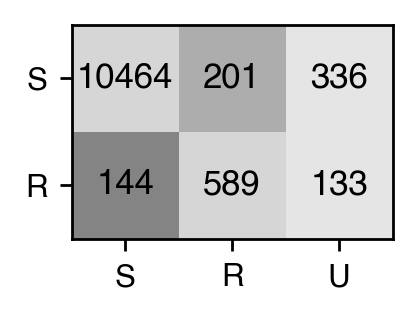

In [44]:
#WHO catalogue tested on our entire dataset
print ('WHOV2 tested on our entire dataset (ternary):')

cm_who, _cov, _who_sens, _who_spec, _FN_ids, _FP_ids = piezo_predict(all, "./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv", "BDQ", Print=True, U_to_S=False)

df_cm_who = pd.DataFrame(cm_who, index=["R", "S"], columns=["R", "S", "U"])

utils.plot_truthtables(df_cm_who, U_to_S=False, colors=["#666666", "#cccccc", "#999999", "#cccccc","#cccccc","#cccccc" ])

### Include LOF aggregate rules

We wouldn't expect any difference to the very major error rate if we included lof aggregation rules ot the catalogue, like the WHO have done (discussed above)- our false negative samples do not contain any mutations in Rv0678, pepQ, or atpE.

 However, it may enable us to classify more resistant samples, which could boost our sensitivity at the cost of specificity.

 We can mirror the WHO's approach by using blanket lof rules that cover all mutations that fall under that rule - stops and indels:

[[  667   135    64]
 [  206 10370   425]]
Catalogue coverage of isolates: 0.9587932923232494
Sensitivity: 0.8316708229426434
Specificity: 0.9805219364599093


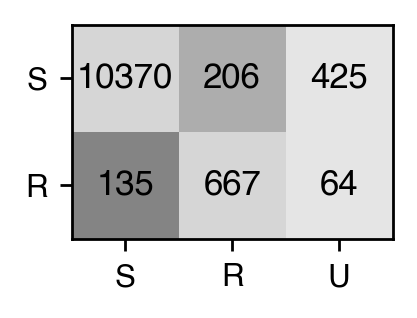

In [45]:
#generate piezo compatible csv 
catalogue_lof.to_piezo("NC_000962.3", f"BDQ-2024.11", "1.1", "BDQ", piezo_wildcards_lof, outfile='./catalogues/manuscript/catomatic_3.csv', include_U=False)

#test catalogue on entire dataset using piezo
cm_lof, _cov, _sens_75, _spec_75, _FN_ids, _FP_ids = piezo_predict(all, f"./catalogues/manuscript/catomatic_3.csv", "BDQ", Print=True, U_to_S=False)

df_cm_lof = pd.DataFrame(cm_lof, index=["R", "S"], columns=["R", "S", "U"])

utils.plot_truthtables(df_cm_lof, U_to_S=False, colors=["#666666", "#cccccc", "#999999", "#cccccc","#cccccc","#cccccc" ])

We manage to correclty classify 60 additional samples as resistant, boosting our sensitivity by 1.5%. It does also allow in more false positives brining our specificy down slightly. We also manage to classify an additional percentage point of samples.

In [46]:
#statistical significance

# Exclude "U" for sensitivity and specificity comparisons
tp1, fn1 = df_cm.loc['R', 'R'], df_cm.loc['R', 'S']
fp1, tn1 = df_cm.loc['S', 'R'], df_cm.loc['S', 'S']
tp2, fn2 = df_cm_lof.loc['R', 'R'], df_cm_lof.loc['R', 'S']
fp2, tn2 = df_cm_lof.loc['S', 'R'], df_cm_lof.loc['S', 'S']

sensitivity_table = [[tp1, fn1], [tp2, fn2]]
specificity_table = [[tn1, fp1], [tn2, fp2]]

chi2_sens, p_sens, _, _ = chi2_contingency(sensitivity_table)
print(f"Sensitivity p-value: {p_sens}")
chi2_spec, p_spec, _, _ = chi2_contingency(specificity_table)
print(f"Specificity p-value: {p_spec}")

Sensitivity p-value: 0.5244935831544977
Specificity p-value: 0.09273363423198526


Or we can take the more cautious approach - add the rules to the wildcards so they are considered in addition to classifications that already exist - ie, only new mutations or those catalogued U will be assumed R. Any S rows will remain as no replacement takes place:

In [47]:
#read in wildcards for piezo catalogues - contains R rules for frameshifts and premature stops
with open('./wildcards/bdq_wildcards_lof_R.json') as f:
    piezo_wildcards_lof = json.load(f)

#we need to remove all U rows, otherwise they overwrite the rule (they have the same effect as unseen mutations so including them makes no difference)
#catalogue.to_piezo("NC_000962.3", f"BDQ-2024.11", "1.1", "BDQ", piezo_wildcards_lof, outfile='./catalogues/manuscript/BDQ_catalogue_lof_2.csv', include_U=False)

#test catalogue on entire dataset using piezo
#cm, _cov, _sens_75, _spec_75, _FN_ids, _FP_ids = piezo_predict(all, f"./catalogues/manuscript/BDQ_catalogue_lof_2.csv", "BDQ", Print=True, U_to_S=False)


While this approach is probably more sensible, and is the one we recommend if one wants to add aggregate rules, in practise it makes no difference as we had no susceptible classifications anyway.

### Cross validation

The greatest limitation of these predictions is that they were made on the training set - owing to limited data availability we can't afford to create an independent validation set. 

To provide some measure of uncertainty in the performance of our catalogue, we can predict sample level phenotypes under 5-fold cross validation.

Performance for 5-fold cross-validated catalogue:

isolate_cov (np.float64(0.9424599831508003), np.float64(0.00397476869825964))
specificity (np.float64(0.984612678426646), np.float64(0.0025858966078588477))
sensitivity (np.float64(0.7936076553683111), np.float64(0.017675875563593523))


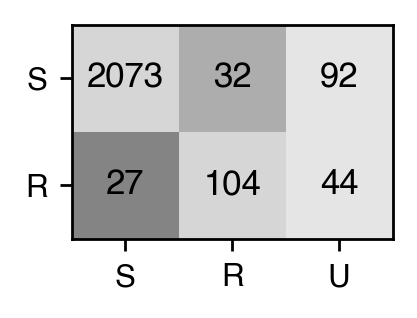

In [48]:
X = all.UNIQUEID.unique()

# create split object
rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
train_indices, test_indices = [], []
# for each fold, create training and test splits
for i, (train_index, test_index) in enumerate(rs.split(X)):
    train_indices.append(train_index)
    test_indices.append(test_index)

# for each fold...
isolate_cov, specificities, sensitivities, cms = [], [], [], []
for fold in range(len(train_indices)):
    train_ids, test_ids = [], []
    # assign samples to the traininga and test sets in each fold
    for i in train_indices[fold]:
        train_ids.append(X[i])
    for j in test_indices[fold]:
        test_ids.append(X[j])

    train_samples = samples[samples.UNIQUEID.isin(train_ids)]
    train_mutations = cat_mutations[cat_mutations.UNIQUEID.isin(train_ids)]
    test_df = all[all.UNIQUEID.isin(test_ids)]
    # construct the catalogue and export as piezo dataframe
    BinaryBuilder(train_samples, train_mutations, FRS=0.1).build(
        test="Binomial",
        tails="two",
        strict_unlock=True,
        background=0.1,
    ).to_piezo(
        "NC_000962.3",
        "BDQ-FRS-0.1-2024.06",
        "1.1",
        "BDQ",
        piezo_wildcards,
        outfile=f"./catalogues/manuscript/catomatic_2b/fold_{str(fold)}.csv",
    )
    # measure performance on that fold's test set
    cm, _cov, _sens, _spec, _FN_ids, _FP_ids = piezo_predict(
        test_df,
        f"./catalogues/manuscript/catomatic_2b/fold_{str(fold)}.csv",
        "BDQ",
        Print=False,
        U_to_S=False,
    )
    isolate_cov.append(_cov)
    specificities.append(_spec)
    # just for the sake of plotting the bar charts - a nan would make plotting impossible
    sensitivities.append(_sens)
    cms.append(cm)

isolate_cov = (np.mean(isolate_cov), np.std(isolate_cov))
specificity = (np.mean(specificities), np.std(specificities))
sensitivity = (np.mean(sensitivities), np.std(sensitivities))

mean = np.mean(cms, axis=0)

labels = [[], []]
for i in range(len(mean)):
    for j in range(len(mean[i])):
        labels[i].append("%s" % int(mean[i][j]))

df_cm = pd.DataFrame(mean, index=["R", "S"], columns=["R", "S", "U"])

print("Performance for 5-fold cross-validated catalogue:\n")

print("isolate_cov", isolate_cov)
print("specificity", specificity)
print("sensitivity", sensitivity)

utils.plot_truthtables(
    df_cm,
    U_to_S=False,
    colors=["#666666", "#cccccc", "#999999", "#cccccc", "#cccccc", "#cccccc"],
)

Performance across the 5 folds is stable, with standard devaitions of sensitivity of 1.8%. 

We see only a slight drop from validating on the entire dataset (likeley because most resistance can be accounted for by a few high frequency mutations which are present in all folds).

# Minor alleles are clinically relevant

The WHOv2 catalogue achieves a max sensitivity of 59.6% and specificity of 98.4%, however this validated on the same dataset used to build the catalogue.

We therefore independently validated their catalogue on our dataset. Validating catalogues on the same dataset also helps facilicate comparisons between performances.

To determine the significance of genetic subpopulations (or minor alleles), the WHO build their catalgoue at a high fraction of read support (FRS), and then test at a high FRS of 0.75 and a low FRS of 0.25. They get a 10% boost in sensitivity - variants associated with resistance are catalogued at high FRS, and also exist at low FRS. Therefore, they are relevant and should be considered.


In [71]:
#validate the WHO catalouge on our data, at FRS 0.75 and 0.25

#test sets
all_75= pd.merge(samples, mutations[(~mutations.GENE.isin(['mmpL5', 'mmpS5']))&(mutations.FRS>=0.75)], how='left', on='UNIQUEID')
all_25= pd.merge(samples, mutations[(~mutations.GENE.isin(['mmpL5', 'mmpS5']))&(mutations.FRS>=0.25)], how='left', on='UNIQUEID')

cm, _cov, _who_sens_75, _who_spec_75, _FN_ids, _FP_ids = piezo_predict(all_75, "./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv", "BDQ", Print=False, U_to_S=True)
cm, _cov, _who_sens_25, _who_spec_25, _FN_ids, _FP_ids = piezo_predict(all_25, "./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv", "BDQ", Print=False, U_to_S=True)

In [ ]:
#Rebuild our catalogue at FRS 0.75

catalogue_75 = BinaryBuilder(samples=samples, mutations=cat_mutations, FRS=0.75).build(tails='two', test='Binomial', background=0.1, strict_unlock=True)
catalogue_75.to_piezo("NC_000962.3", f"BDQ-FRS-75-2024.11", "1.1", "BDQ", piezo_wildcards, outfile='./catalogues/manuscript/catomatic_4.csv')
catalogue_75.to_piezo("NC_000962.3", f"BDQ-FRS-75-2024.11", "1.1", "BDQ", piezo_wildcards, outfile='./catalogues/manuscript/catomatic_5.csv')
#catomatic 1 and 2 are the same catalogue, just evaluated at different FRS

cm_75, _cov, _sens_75, _spec_75, _FN_ids, _FP_ids = piezo_predict(all_75, f"./catalogues/manuscript/catomatic_4.csv", "BDQ", Print=False, U_to_S=True)
cm_25, _cov, _sens_25, _spec_25, _FN_ids, _FP_ids = piezo_predict(all_25, f"./catalogues/manuscript/catomatic_5.csv", "BDQ", Print=False, U_to_S=True)

#filter out seeded and default rule rows for ctalogue counts
cat_75_df = catalogue_75.build_piezo("NC_000962.3", f"BDQ-2024.11", "1.1", "BDQ", piezo_wildcards)

cat_75_df = cat_75_df[~cat_75_df['EVIDENCE'].apply(lambda x: any(key in x for key in ['seeded', 'default_rule']))]

print ('Total classifications count:\n', cat_75_df.PREDICTION.value_counts())

Total classifications count:
 PREDICTION
U    202
R     67
S      0
Name: count, dtype: int64


In [73]:
#statistical significance

df_cm_75 = pd.DataFrame(cm_75, index=["R", "S"], columns=["R", "S"])
df_cm_25 = pd.DataFrame(cm_25, index=["R", "S"], columns=["R", "S"])

tp1, fn1 = df_cm_75.loc['R', 'R'], df_cm_75.loc['R', 'S']
fp1, tn1 = df_cm_75.loc['S', 'R'], df_cm_75.loc['S', 'S']
tp2, fn2 = df_cm_25.loc['R', 'R'], df_cm_25.loc['R', 'S']
fp2, tn2 = df_cm_25.loc['S', 'R'], df_cm_25.loc['S', 'S']

sensitivity_table = [[tp1, fn1], [tp2, fn2]]
specificity_table = [[tn1, fp1], [tn2, fp2]]

chi2_sens, p_sens, _, _ = chi2_contingency(sensitivity_table)
print(f"Sensitivity p-value: {p_sens}")
chi2_spec, p_spec, _, _ = chi2_contingency(specificity_table)
print(f"Specificity p-value: {p_spec}")

Sensitivity p-value: 1.3012522799096085e-05
Specificity p-value: 0.16577619283238162


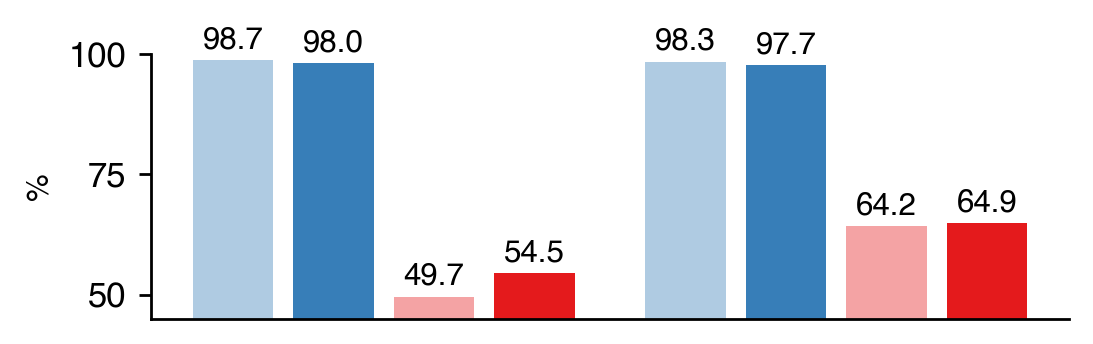

In [74]:
# combine performance charts into one axis
performance = {
    0.75: {
        # "WHOv2 data": {"Sensitivity": 49.4, "Specificity": 98.7},
        "Our data": {
            "Sensitivity": _who_sens_75 * 100,
            "Specificity": _who_spec_75 * 100,
        },
        "Our catalogue": {"Sensitivity": _sens_75 * 100, "Specificity": _spec_75 * 100},
    },
    0.25: {
        # "WHOv2": {"Sensitivity": 59.6, "Specificity": 98.4},
        "Our data": {
            "Sensitivity": _who_sens_25 * 100,
            "Specificity": _who_spec_25 * 100,
        },
        "Our catalogue": {"Sensitivity": _sens_25 * 100, "Specificity": _spec_25 * 100},
    },
}

# utils.compare_metrics_groups(performance, figsize=(6.5, 4))

# plot is correct but struggling to get seaborn to handle the spacing of the groups, so do more manually

performance = {
    "who_spec_75": _who_spec_75 * 100,
    "our_spec_75": _spec_75 * 100,
    "who_sens_75": _who_sens_75 * 100,
    "our_sens_75": _sens_75 * 100,
    "who_spec_25": _who_spec_25 * 100,
    "our_spec_25": _spec_25 * 100,
    "who_sens_25": _who_sens_25 * 100,
    "our_sens_25": _sens_25 * 100,

}

colors = ['#377eb8', '#377eb8', '#e41a1c', '#e41a1c', '#377eb8', '#377eb8', '#e41a1c', '#e41a1c']
alphas = [0.4, 1.0, 0.4, 1.0, 0.4, 1.0, 0.4, 1.0]
positions = [0, 1, 2, 3, 4.5, 5.5, 6.5, 7.5]


# Create figure and axis
fig, ax = plt.subplots(figsize=(4.5, 1.5))

# Create the bar plot with custom positions, colors, and opacities
for i, (key, value) in enumerate(performance.items()):
    ax.bar(positions[i], value, color=colors[i], alpha=alphas[i])

# Add value labels above bars
for i, (key, value) in enumerate(performance.items()):
    plt.text(positions[i], value + 1, f"{value:.1f}", ha="center", va="bottom", fontsize=9)

# Set y-axis label and customize y-axis ticks
plt.ylabel("%", fontsize=9)
ax.set_yticks([50, 75, 100])  # Set specific tick values
ax.tick_params(axis='y', labelsize=10)  # Set font size for y-axis ticks

# Remove x-axis ticks and adjust limits
ax.set_xticks([])
plt.ylim(45, 100)

# Finalize plot style
sns.despine()
plt.tight_layout()

# Save and show plot
plt.savefig("pdf/results_barchart.pdf", format="pdf", bbox_inches="tight")
plt.show()

Like WHOv2, When we validate our catalogues under the same conditions using the same prediction protocol, we see an increase when dropping the test threshold - we predict resistance for more samples when dropping the FRS.

Let's see what it looks like under our prediction protocol (ie use ternary prediction system)

In [75]:
#don't assume unkowns are S
cm, _who_cov_75, _who_sens_75, _who_spec_75, _FN_ids, _FP_ids = piezo_predict(all_75, "./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv", "BDQ", Print=False, U_to_S=False)
cm, _who_cov_25, _who_sens_25, _who_spec_25, _FN_ids, _FP_ids = piezo_predict(all_25, "./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv", "BDQ", Print=False, U_to_S=False)

cm_75, _cov_75, _sens_75, _spec_75, _FN_ids, _FP_ids = piezo_predict(all_75, f"./catalogues/manuscript/catomatic_4.csv", "BDQ", Print=False, U_to_S=False)
cm_25, _cov_25, _sens_25, _spec_25, _FN_ids, _FP_ids = piezo_predict(all_25, f"./catalogues/manuscript/catomatic_5.csv", "BDQ", Print=False, U_to_S=False)

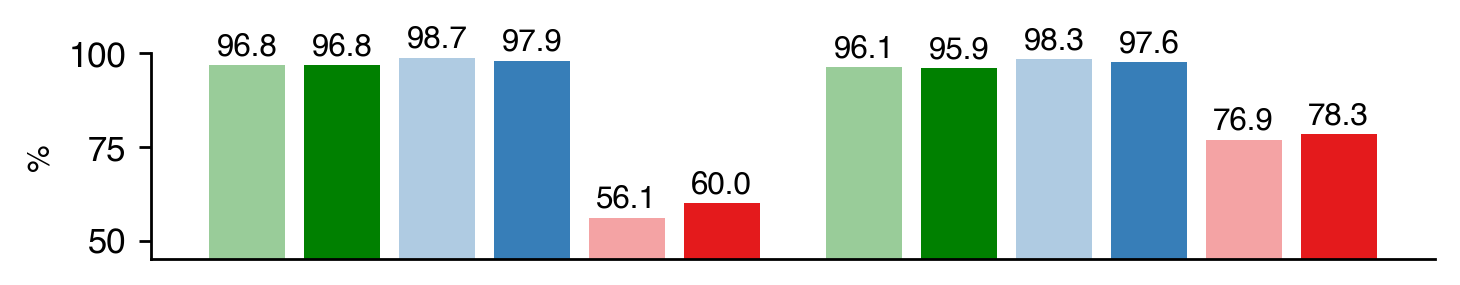

In [163]:
performance = {
    "who_cov_75": _who_cov_75*100,
    "our_cov_75": _cov_75*100,
    "who_spec_75": _who_spec_75 * 100,
    "our_spec_75": _spec_75 * 100,
    "who_sens_75": _who_sens_75 * 100,
    "our_sens_75": _sens_75 * 100,
    "who_cov_25": _who_cov_25*100,
    "our_cov_25": _cov_25*100,
    "who_spec_25": _who_spec_25 * 100,
    "our_spec_25": _spec_25 * 100,
    "who_sens_25": _who_sens_25 * 100,
    "our_sens_25": _sens_25 * 100,

}

colors = ['green', 'green', '#377eb8', '#377eb8', '#e41a1c', '#e41a1c', 'green', 'green', '#377eb8', '#377eb8', '#e41a1c', '#e41a1c', ]
alphas = [0.4, 1.0, 0.4, 1.0, 0.4, 1.0, 0.4, 1.0, 0.4, 1.0, 0.4, 1.0]
positions = [0, 1, 2, 3, 4, 5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5]


# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 1.3))

# Create the bar plot with custom positions, colors, and opacities
for i, (key, value) in enumerate(performance.items()):
    ax.bar(positions[i], value, color=colors[i], alpha=alphas[i])

# Add value labels above bars
for i, (key, value) in enumerate(performance.items()):
    plt.text(positions[i], value + 1, f"{value:.1f}", ha="center", va="bottom", fontsize=9)

# Set y-axis label and customize y-axis ticks
plt.ylabel("%", fontsize=9)
ax.set_yticks([50, 75, 100])  # Set specific tick values
ax.tick_params(axis='y', labelsize=10)  # Set font size for y-axis ticks

# Remove x-axis ticks and adjust limits
ax.set_xticks([])
plt.ylim(45, 100)

# Finalize plot style
sns.despine()
plt.tight_layout()

# Save and show plot
plt.savefig("pdf/results_barchart.pdf", format="pdf", bbox_inches="tight")
plt.show()

(Will have to manually put tick labels on)

In [55]:
df_cm_75 = pd.DataFrame(cm_75, index=["R", "S"], columns=["R", "S", "U"])
df_cm_25 = pd.DataFrame(cm_25, index=["R", "S"], columns=["R", "S", "U"])

# Extracting counts for sensitivity and specificity calculations
tp1, fn1 = df_cm_75.loc['R', 'R'], df_cm_75.loc['R', 'S']
fp1, tn1 = df_cm_75.loc['S', 'R'], df_cm_75.loc['S', 'S']
tp2, fn2 = df_cm_25.loc['R', 'R'], df_cm_25.loc['R', 'S']
fp2, tn2 = df_cm_25.loc['S', 'R'], df_cm_25.loc['S', 'S']

sensitivity_table = [[tp1, fn1], [tp2, fn2]]
specificity_table = [[tn1, fp1], [tn2, fp2]]

chi2_sens, p_sens, _, _ = chi2_contingency(sensitivity_table)
print(f"Sensitivity p-value: {p_sens}")
chi2_spec, p_spec, _, _ = chi2_contingency(specificity_table)
print(f"Specificity p-value: {p_spec}")

#coverage
non_u_75 = df_cm_75["R"].sum() + df_cm_75["S"].sum()
total_75 = df_cm_75.values.sum()
u_75 = total_75 - non_u_75
non_u_25 = df_cm_25["R"].sum() + df_cm_25["S"].sum()
total_25 = df_cm_25.values.sum()
u_25 = total_25 - non_u_25

coverage_table = [[non_u_75, u_75], [non_u_25, u_25]]

# Chi-squared test for Coverage
chi2_cov, p_cov, _, _ = chi2_contingency(coverage_table)
print(f"Coverage p-value: {p_cov}")

Sensitivity p-value: 3.179233144471584e-14
Specificity p-value: 0.15274692628724745
Coverage p-value: 0.000143682190866005



However, if minor alleles are relevant, then logically one should build the catalogue at a low FRS ensure they've been captured.

Becuase our approach is algorithmic and deterministic, we can build our catalogues across the FRS range and test them on the entire dataset - this will give a more informative idea of minor alleles significance - if we get a drop in sensitivity when raising the threshold, then there are variants in the dataset that are phenotypically significant but have only been ovesrved with low read support/as minor alleles:

In [56]:
results = []

for i in np.arange(0.1, 1, 0.01):
    # Build and save catalogue across FRS range
    catalogue_name = f"BDQ-{int(i*100)}-2024.11"
    csv_path = f"./catalogues/manuscript/var_frs/catalogue_{int(i*100)}.csv"
    
    catalogue =  BinaryBuilder(samples, cat_mutations, FRS=i).build(test='Binomial', tails='two', strict_unlock=True, background=0.1)        
    catalogue.to_piezo("NC_000962.3", catalogue_name, "1.1", "BDQ", piezo_wildcards, outfile=f"./catalogues/manuscript/var_frs/catalogue_{int(i*100)}.csv")
    #save catalogue at FRS 0.9 as catomatic 7
    if np.round(i, 2) == 0.9:
        catalogue.to_piezo("NC_000962.3", catalogue_name, "1.1", "BDQ", piezo_wildcards, outfile=f"./catalogues/manuscript/catomatic_6.csv")

    
    # Predict with catalogue at FRS 0.1
    cm, _cov, _sens, _spec, _FN_ids, _FP_ids = piezo_predict(
        all, 
        csv_path, 
        "BDQ", 
        Print=False, 
        U_to_S=False
    )

    if np.round(i, 2) == 0.1:
        df_cm_10 = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])
    if np.round(i, 2) == 0.9:
        df_cm_90 = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])
    
    results.append((i, _sens * 100, _spec * 100, _cov * 100, _FN_ids))

# Create DataFrame
data = pd.DataFrame(results, columns=["FRS", "Sensitivity", "Specificity", "Coverage", "FNs"])

# Plot the results

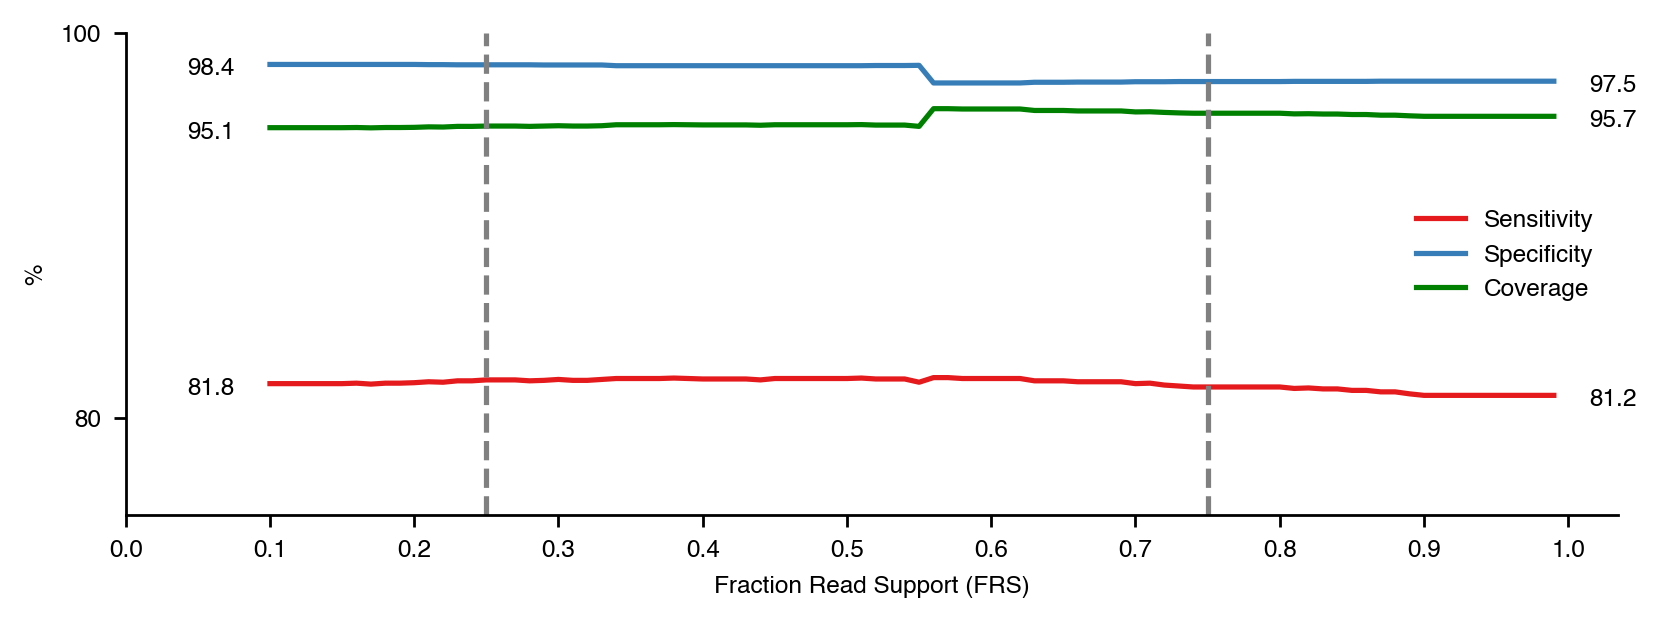

In [57]:
utils.FRS_vs_metric(data[['FRS', 'Sensitivity', 'Specificity', 'Coverage']], cov=True)

In [58]:
tp1, fn1 = df_cm_10.loc['R', 'R'], df_cm_10.loc['R', 'S']
fp1, tn1 = df_cm_10.loc['S', 'R'], df_cm_10.loc['S', 'S']
tp2, fn2 = df_cm_90.loc['R', 'R'], df_cm_90.loc['R', 'S']
fp2, tn2 = df_cm_90.loc['S', 'R'], df_cm_90.loc['S', 'S']

sensitivity_table = [[tp1, fn1], [tp2, fn2]]
specificity_table = [[tn1, fp1], [tn2, fp2]]

chi2_sens, p_sens, _, _ = chi2_contingency(sensitivity_table)
print(f"Sensitivity p-value: {p_sens}")
chi2_spec, p_spec, _, _ = chi2_contingency(specificity_table)
print(f"Specificity p-value: {p_spec}")

# Coverage calculation
non_u_10 = df_cm_10["R"].sum() + df_cm_10["S"].sum()
total_10 = df_cm_10.values.sum()
u_10 = total_10 - non_u_10
non_u_90 = df_cm_90["R"].sum() + df_cm_90["S"].sum()
total_90 = df_cm_90.values.sum()
u_90 = total_90 - non_u_90

coverage_table = [[non_u_10, u_10], [non_u_90, u_90]]

chi2_cov, p_cov, _, _ = chi2_contingency(coverage_table)
print(f"Coverage p-value: {p_cov}")

Sensitivity p-value: 0.8166862344618017
Specificity p-value: 1.0997771660075856e-05
Coverage p-value: 0.0328364100378542


We don't really see any real change - minor alleles do exist, but we capture and catalogue them at high FRS - this agrees with WHOv2.

It would therefore seem building at varying FRS has no effect, but evaluating does. Let's compare both:

In [39]:
build_frs_values = np.arange(0.1, 1.0, 0.1)
test_frs_values = np.arange(0.1, 1.0, 0.1)

manager = mp.Manager()
sensitivity_matrix = manager.dict()
specificity_matrix = manager.dict()
coverage_matrix = manager.dict()

def process_build_frs(build_frs):
    catalogue_name = f"BDQ-{int(build_frs*100)}-2024.11"
    csv_path = f"./catalogues/manuscript/var_frs/catalogue_{int(build_frs*100)}.csv"
    
    catalogue = BinaryBuilder(samples, cat_mutations, FRS=build_frs).build(test='Binomial', tails='two', strict_unlock=True, background=0.1)
    catalogue.to_piezo("NC_000962.3", catalogue_name, "1.1", "BDQ", piezo_wildcards, outfile=csv_path)
    sens_results, spec_results, cov_results = {}, {}, {}

    for test_frs in test_frs_values:
        all_frs = pd.merge(samples, mutations[(~mutations.GENE.isin(['mmpL5', 'mmpS5'])) & (mutations.FRS >= test_frs)], on='UNIQUEID', how='left')
        
        cm, _cov, _sens, _spec, _FN_ids, _FP_ids = piezo_predict(
            all_frs,
            csv_path,
            "BDQ",
            Print=False,
            U_to_S=False
        )
        sens_results[test_frs] = _sens * 100
        spec_results[test_frs] = _spec * 100
        cov_results[test_frs] = _cov * 100

    sensitivity_matrix[build_frs] = sens_results
    specificity_matrix[build_frs] = spec_results
    coverage_matrix[build_frs] = cov_results

mp.set_start_method('fork', force=True)  
pool = mp.Pool(mp.cpu_count() - 1)
pool.map(process_build_frs, build_frs_values)
pool.close()
pool.join()

sensitivity_df = pd.DataFrame.from_dict(sensitivity_matrix, orient="index").sort_index()
specificity_df = pd.DataFrame.from_dict(specificity_matrix, orient="index").sort_index()
coverage_df = pd.DataFrame.from_dict(coverage_matrix, orient="index").sort_index()



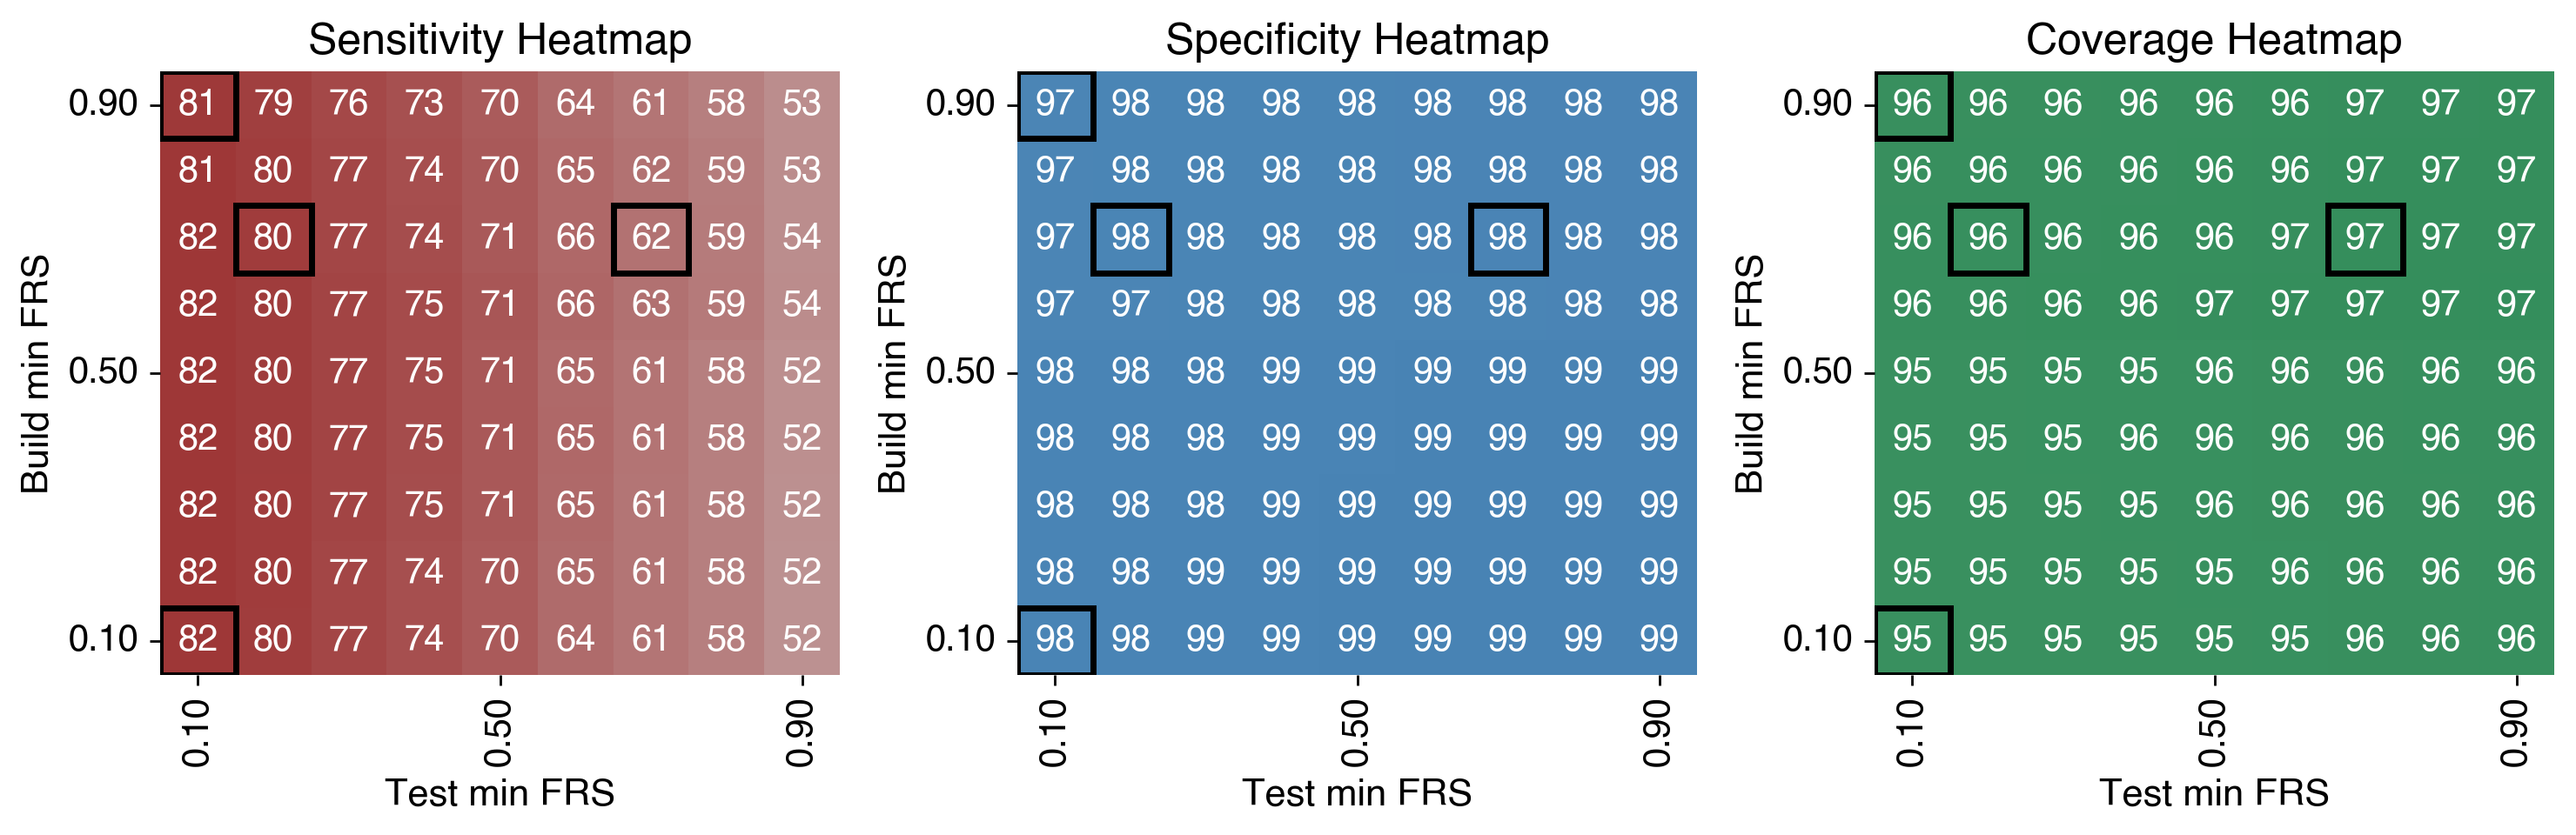

In [40]:
custom_cmap = mcolors.LinearSegmentedColormap.from_list("red_gray", ["#D3D3D3", "#8B0000"])  


red_gray_cmap = mcolors.LinearSegmentedColormap.from_list("red_gray", ["#D3D3D3", "#8B0000", ])  # Dark red → Light gray
blue_gray_cmap = mcolors.LinearSegmentedColormap.from_list("blue_gray", ["#D3D3D3", "#4682B4", ])  # Dark blue → Light gray
green_gray_cmap = mcolors.LinearSegmentedColormap.from_list("green_gray", ["#D3D3D3", "#2E8B57", ])  # Dark green → Light gray

# Assign colormaps to respective heatmaps
colormaps = [red_gray_cmap, blue_gray_cmap, green_gray_cmap]

plt.rcParams["figure.dpi"] = 250
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (6.69, 5.02)

highlighted_cells = [(8, 0), (6, 1), (6, 6), (0, 0)]  # Modify these based on your data

# Define the specific tick positions and labels
selected_ticks = [0.1, 0.5, 0.9]  # Values to display on both axes

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, (df, title, cmap) in enumerate(zip([sensitivity_df, specificity_df, coverage_df], 
                                          ["Sensitivity Heatmap", "Specificity Heatmap", "Coverage Heatmap"],
                                          colormaps)):
    ax = sns.heatmap(df, annot=True, cmap=cmap, ax=axes[i], vmin=30, vmax=100, cbar=False)
    ax.set_title(title)
    ax.set_xlabel("Test min FRS", fontsize=12.5)
    ax.set_ylabel("Build min FRS", fontsize=12.5)
    ax.invert_yaxis()  # Make sure the y-axis starts with the smallest value

    # Set custom tick labels
    ax.set_xticks([df.columns.get_loc(tick)+0.5 for tick in selected_ticks])  # Find column positions for 0.1, 0.5, 0.9
    ax.set_xticklabels([f"{tick:.2f}" for tick in selected_ticks])

    ax.set_yticks([df.index.get_loc(tick)+0.5 for tick in selected_ticks])  # Find row positions for 0.1, 0.5, 0.9
    ax.set_yticklabels([f"{tick:.2f}" for tick in selected_ticks])

    # Add boxes to highlight important areas
    for row, col in highlighted_cells:
        rect = patches.Rectangle((col, row), 1, 1, linewidth=2, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

plt.tight_layout()
plt.show()


## Is there a correlation between FRS and resistance?

We hypothesised that resistant alleles existing at higher prevalence in mixed populations will induce a greater level of resistance because of reduced time taken for visible growth during MGIT or culture based testing. We accordingly examined whether there is a correlation between FRS and MIC post incubation across isolates with only one resistant mutation (and any number of susceptible mutations) for any Rv0678 mutations and for Rv0678 141-ins-c, which has the highest incidence and FRS variance.

In [59]:
all.METHOD_3.value_counts()

METHOD_3
UKMYC6     6925
UKMYC5     4442
MGIT960    1438
Name: count, dtype: int64

In [60]:
all["MIC_FLOAT"] = utils.mic_to_float(all["METHOD_MIC"].tolist())

R_muts = catalogue_df[catalogue_df.PREDICTION == "R"].MUTATION.tolist()
# should only look at samples with a single R mutation (can have multipled S) that has been catalogued as R
ids, solo_Rs = all[all.METHOD_3.isin(['UKMYC5', 'UKMYC6'])].UNIQUEID.unique(), []
for i in ids:
    df = all[all.UNIQUEID == i]
    if len(df[(df.MUTATION.isin(R_muts))]) == 1:
        solo_Rs.append(i)
#create a dataframe with binned FRS and MIC values
df_mic = pd.DataFrame.from_dict(
    {"UNIQUEID": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.MUTATION.isin(R_muts))
        ].UNIQUEID.tolist(),
        "MUTATION": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.MUTATION.isin(R_muts))
        ].MUTATION.tolist(),
        "FRS": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.MUTATION.isin(R_muts))
        ].FRS.tolist(),
        "MIC": [
            i
            for i in (
                (
                    all[
                        (all.UNIQUEID.isin(solo_Rs)) & (all.MUTATION.isin(R_muts))
                    ].MIC_FLOAT
                )
            ).tolist()
        ],
    }
)

df_mic["binned_FRS"] = [str(round(i, 1)) for i in df_mic.FRS.tolist()]
df_mic["binned_MIC"] = [str(i) for i in df_mic.MIC]
df_mic["MIC"] = [str(i) for i in df_mic.MIC]



In [61]:
df_mic[df_mic.FRS < 0.9].MIC.value_counts()

MIC
0.06     19
0.5      13
0.25      9
0.03      5
0.12      5
0.015     3
1.0       3
0.008     1
Name: count, dtype: int64

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_90632/380210671.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_90632/380210671.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(


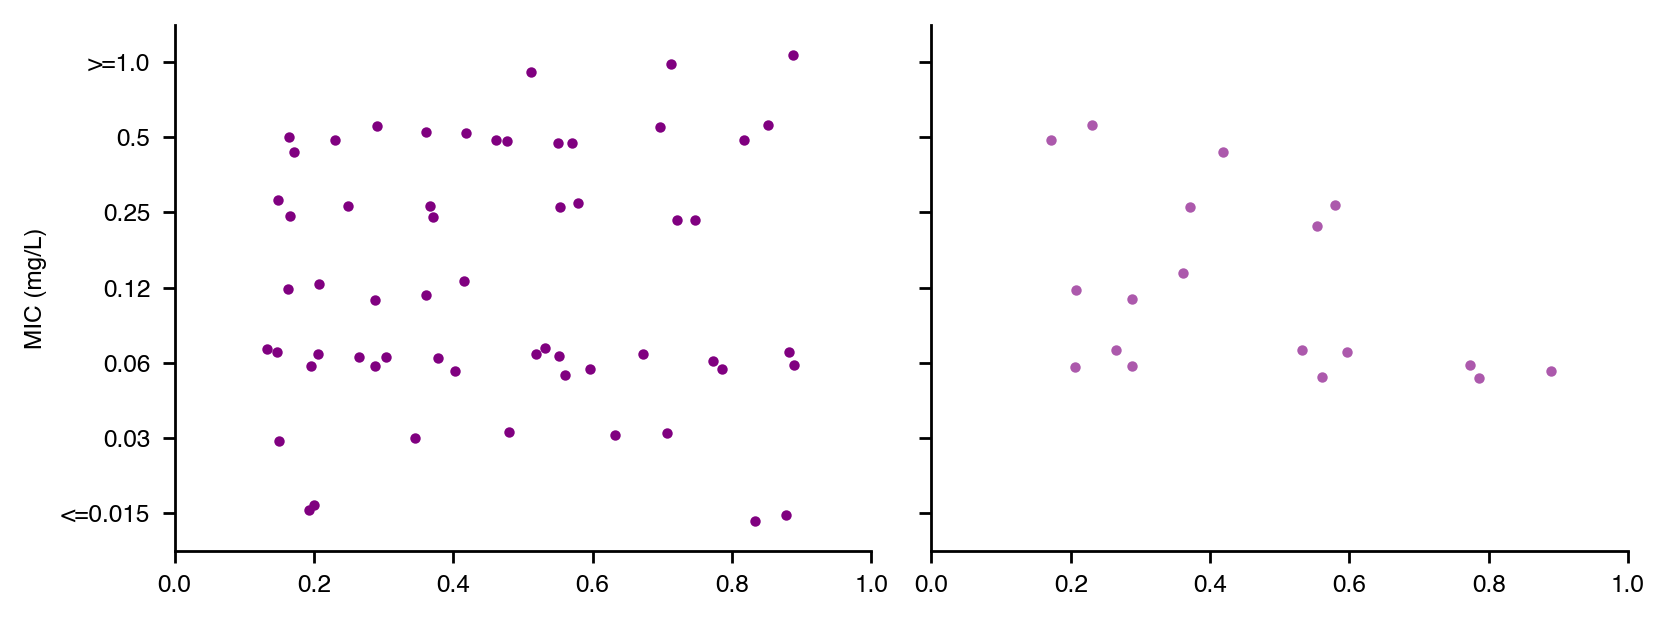

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6.69, 2.5))

#collapse tails, as they don't align across palte designs
df_mic['MIC'] = df_mic['MIC'].replace({'0.008': '0.015', '2': '1'})


# axes[0].set_ylim(0, 3.5)
y_axis_order = [
    "0.015",
    "0.03",
    "0.06",
    "0.12",
    "0.25",
    "0.5",
    "1.0",

]
#plot FRS vs MIC for pooled variants with FRS below 0.9 (ie heteresistant variants), for all Rv0678 solos
sns.stripplot(
    x="FRS", y="MIC", data=df_mic[df_mic.FRS < 0.9], ax=axes[0], jitter=0.2, order=y_axis_order, size=3, color='purple'
)
axes[0].invert_yaxis()
axes[0].set_yticklabels(
    [ "<=0.015", "0.03", "0.06", "0.12", "0.25", "0.5", ">=1.0"]
)
axes[0].set_ylabel("MIC (mg/L)")
axes[0].set_xlabel("")
axes[0].tick_params(axis="both")
axes[0].set_xlim(0, 1)
#plot FRS vs MIC for variants with FRS below 0.9 (ie heteresistant variants), for 141_ins_c, the most frequently observed heteresistant mutation
sns.stripplot(
    x="FRS",
    y="MIC",
    data=df_mic[(df_mic.MUTATION == "Rv0678@141_ins_c") & (df_mic.FRS < 0.9)],
    ax=axes[1],
    jitter=0.2,
    color="purple",
    order=y_axis_order,
    size=3,
    alpha=0.65
)
axes[1].invert_yaxis()
axes[1].set_yticklabels(
    [ "<=0.015", "0.03", "0.06", "0.12", "0.25", "0.5", ">=1.0"]
)
axes[1].set_xlim(0, 1)
axes[1].set_ylabel("")
axes[1].set_xlabel("")
axes[1].tick_params(axis="both", )
axes[1].set_yticklabels([])
plt.tight_layout()
sns.despine()

plt.show()

## Is there a correlation between FRS and Growth?

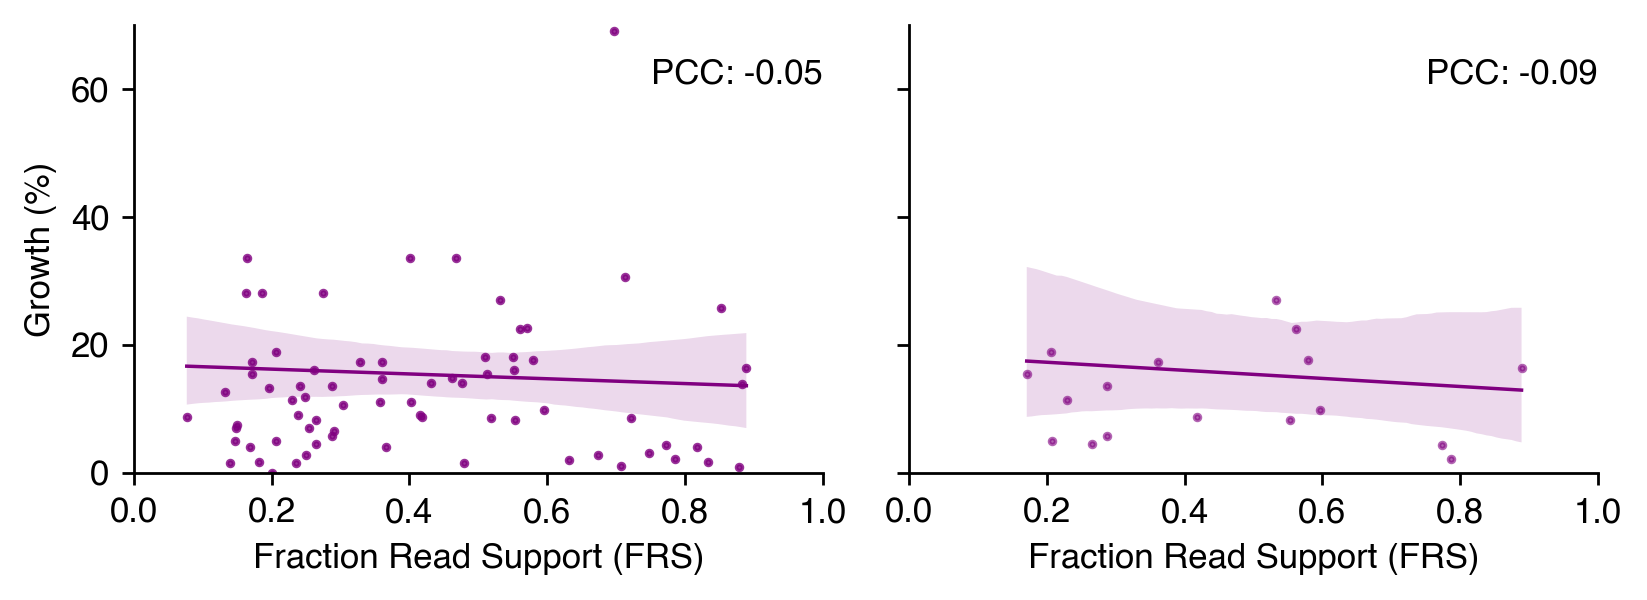

In [63]:
plt.rcParams['font.size'] = 10


growth_dil = growth[(growth.WELL_CONC.isin([0.015, 0.03])) & (growth.READINGDAY == 14)]# subset growth data to dilutions of 1, 2, or 3 fold so there is drug present, and only look at growth at 14 days post incubation
growth_dil = growth_dil[["UNIQUEID", "GROWTH"]].groupby("UNIQUEID").mean()
# average growth across dilutions

df_growth = pd.merge(growth_dil, cat_mutations[cat_mutations.GENE=='Rv0678'], how='inner', on='UNIQUEID')
#filter for samples with only a single resistant mutation (and however many S)
df_growth  = df_growth [df_growth .UNIQUEID.isin(solo_Rs)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6.69, 2.5))
#plot FRS vs growth for pooled variants with FRS below 0.9 (ie heteresistant variants), for all Rv0678 solos
sns.regplot(x="FRS", y="GROWTH", data=df_growth [df_growth .FRS < 0.9], ax=axes[0], ci=95, scatter_kws={"s": 3}, color='purple',     line_kws={"linewidth": 1}  # Reduce the width of the regression line
)  
axes[0].set_xlim(0.0, 1)
axes[0].set_ylim(0, 70)
axes[0].set_xlabel("Fraction Read Support (FRS)",)
axes[0].set_ylabel("Growth (%)")
axes[0].tick_params(axis="both", )
# Calculate Pearson correlation coefficient
pcc_value = df_growth [df_growth .FRS < 0.9][["FRS", "GROWTH"]].corr().iloc[0, 1]
# Annotate the first subplot with the PCC value
axes[0].annotate(
    f"PCC: {pcc_value:.2f}",
    xy=(0.75, 0.87),
    xycoords="axes fraction",
    color="black",
)
#plot FRS vs MIC for variants with FRS below 0.9 (ie heteresistant variants), for 141_ins_c, the most frequently observed heteresistant mutation
sns.regplot(
    x="FRS",
    y="GROWTH",
    data=df_growth[(df_growth.MUTATION == "Rv0678@141_ins_c") & (df_growth.FRS < 0.9)],
    ax=axes[1],
    color="purple",
    ci=95,
    scatter_kws={"s": 3, 'alpha':0.6},  # Use this to control marker size (50 is an example, adjust as needed),
    line_kws={"linewidth": 1}  # Reduce the width of the regression line

)
axes[1].set_xlim(0.0, 1)  # Set x-axis range
axes[1].set_ylim(0, 70)
axes[1].set_ylabel("")
axes[1].set_xlabel("Fraction Read Support (FRS)")
axes[1].tick_params(axis="both")
axes[1].set_yticklabels([])

# Calculate Pearson correlation coefficient
pcc_value = (
    df_growth[(df_growth.FRS < 0.9) & (df_growth.MUTATION == "Rv0678@141_ins_c")][["FRS", "GROWTH"]]
    .corr()
    .iloc[0, 1]
)
# Annotate the first subplot with the PCC value
axes[1].annotate(
    f"PCC: {pcc_value:.2f}",
    xy=(0.75, 0.87),
    xycoords="axes fraction",
    color="black",
)

sns.despine()
plt.tight_layout()

plt.show()

UKMYC6


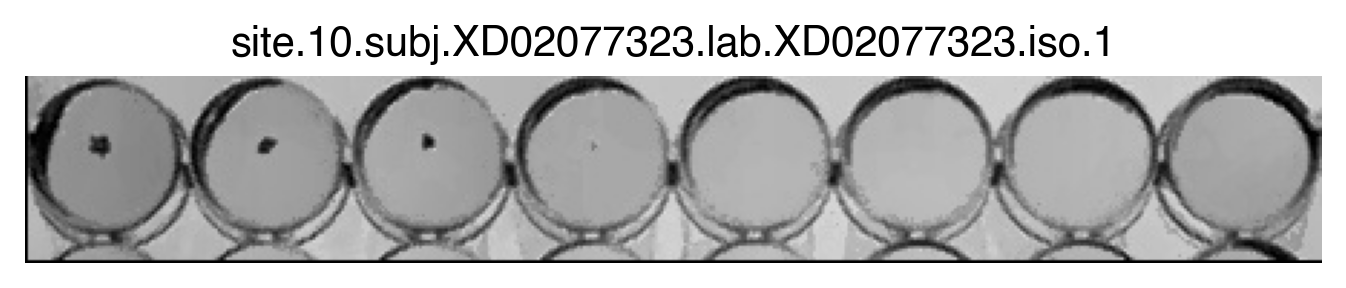

UKMYC6


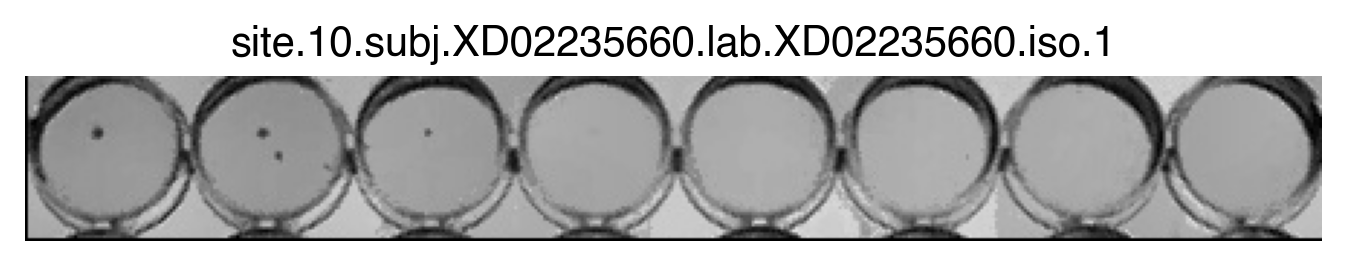

UKMYC6


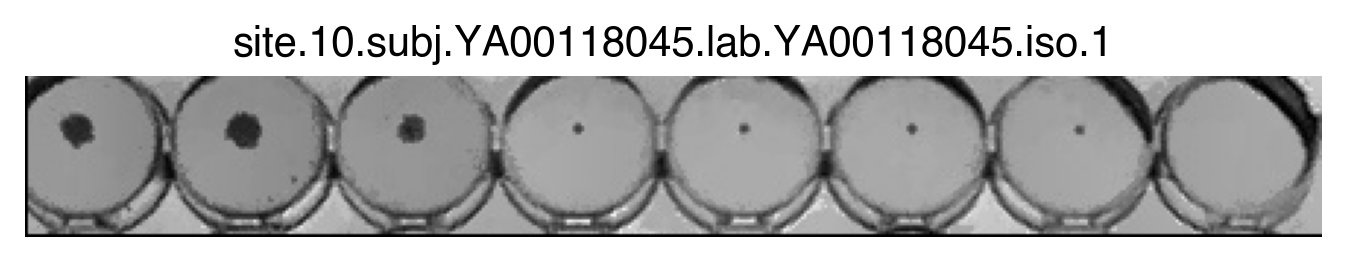

In [64]:

filenames = os.listdir('./imgs/growth_images/')

# Display the filenames
imgs = {k[:-21]: k for k in filenames if k[-7:-4]=='BDQ'}

img_df = df_growth[df_growth.UNIQUEID.isin(imgs.keys())].sort_values(by=['FRS'])
bottom_3 = img_df[img_df.MUTATION=='Rv0678@141_ins_c'][:4].UNIQUEID.values
top_3 = img_df[img_df.MUTATION=='Rv0678@141_ins_c'][-3:].UNIQUEID.values


image_dir = "./imgs/growth_images/"  # Adjust the path as needed

# Display each image
for img_name in top_3:
    try:
        img_path = f"{image_dir}{img_name}.UKMYC5-strip.BDQ.jpg"  
        img = mpimg.imread(img_path)
        print ("UKMYC5")

    except:
        img_path = f"{image_dir}{img_name}.UKMYC6-strip.BDQ.jpg"  
        img = mpimg.imread(img_path)
        print ("UKMYC6")


    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)
    plt.show()

There is no correlation between FRS and MIC, and FRS and growth, for Rv0678 resistant variants generally, as well as for the most variable (wrt FRS) mutations in Rv0678. This would suggest there is no effective fitness cost resulting from Rv0678 resistant mutations, as minor resistant populations can rapidly outcompete major WT populations. 

Minor alleles are clinically significant therefore, and must be included in the catalogue by dropping the FRS threshold to a minimum (we could only get down to 0.1, so we do not know where the breakpoint should be).

# Epistasis between Rv0678 and LoF mmpL5

Is there actually a link between Rv0678 and LoF mutations in mmpL5? And can we really call it epistasis?

### MGIT samples

In [65]:
mutations['IS_STOP'] = [True if i[-1] == '!' else False for i in mutations.MUTATION]

nicd_samples = pd.merge(phenotypes_nicd.reset_index(drop=True), genomes, how='inner', on=['UNIQUEID'])
all_nicd = pd.merge(mutations, nicd_samples, how='right', on=['UNIQUEID'])

nicd_LoF_ids = all_nicd[(all_nicd.GENE=='mmpL5')&((~all_nicd.INDEL_LENGTH.isna())|(all_nicd.IS_STOP==True))].UNIQUEID
all_nicd[all_nicd.UNIQUEID.isin(nicd_LoF_ids)].MUTATION.value_counts()

MUTATION
mmpL5@I948V         2
mmpL5@345_del_ac    2
Name: count, dtype: int64

Pretty meaningless - only 2 samples that contain a LoF (indel or stop) in mmpL5, and the only co-occurent mutations is the phylogenetic I948V.0

Lets try the cryptic samples:

### CRyPTIC samples

In [66]:
cryptic_samples = pd.merge(phenotypes_cryptic.reset_index(drop=True), genomes, how='inner', on=['UNIQUEID'])
all_cryptic = pd.merge(mutations, cryptic_samples, how='right', on=['UNIQUEID'])
all_cryptic = all_cryptic[all_cryptic.IS_SYNONYMOUS==False]

cryptic_LoF_ids = all_cryptic[(all_cryptic.GENE=='mmpL5')&((~all_cryptic.INDEL_LENGTH.isna())|(all_cryptic.IS_STOP==True))].UNIQUEID.unique()
cryptic_LoF_vars = all_cryptic[(all_cryptic.GENE=='mmpL5')&((~all_cryptic.INDEL_LENGTH.isna())|(all_cryptic.IS_STOP==True))].MUTATION.unique()
lofs = all_cryptic[all_cryptic.UNIQUEID.isin(cryptic_LoF_ids)]
lofs

,index,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,...,SUBJID,LABID,ISOLATENO,SEQREPS,CLOCKWORK_VERSION,FTP_PATH,FTP_FILENAME_VCF,TREE_PATH,TREE_FILENAME_VCF,WGS_PREDICTION_STRING
135,45483.0,site.02.subj.0076.lab.22A028.iso.1,mmpL5,mmpL5@D767N,gac,aac,NaN,NaN,767.0,True,...,0076,22A028,1,28,0.12.4,vcfs/jeffk-20230406/,00/01/14/55/11455/site.02.iso.1.subject.0076.l...,dat/CRyPTIC2/V2/02/0076/22A028/1/per_sample/,site.02.subj.0076.lab.22A028.iso.1.v0.12.4.per...,RRSRSSSSS SSSS
136,45484.0,site.02.subj.0076.lab.22A028.iso.1,mmpL5,mmpL5@T794I,acc,atc,NaN,NaN,794.0,True,...,0076,22A028,1,28,0.12.4,vcfs/jeffk-20230406/,00/01/14/55/11455/site.02.iso.1.subject.0076.l...,dat/CRyPTIC2/V2/02/0076/22A028/1/per_sample/,site.02.subj.0076.lab.22A028.iso.1.v0.12.4.per...,RRSRSSSSS SSSS
137,45485.0,site.02.subj.0076.lab.22A028.iso.1,mmpL5,mmpL5@I948V,att,gtt,NaN,NaN,948.0,True,...,0076,22A028,1,28,0.12.4,vcfs/jeffk-20230406/,00/01/14/55/11455/site.02.iso.1.subject.0076.l...,dat/CRyPTIC2/V2/02/0076/22A028/1/per_sample/,site.02.subj.0076.lab.22A028.iso.1.v0.12.4.per...,RRSRSSSSS SSSS
138,45486.0,site.02.subj.0076.lab.22A028.iso.1,mmpL5,mmpL5@2752_del_ac,NaN,NaN,2752.0,775728.0,2752.0,True,...,0076,22A028,1,28,0.12.4,vcfs/jeffk-20230406/,00/01/14/55/11455/site.02.iso.1.subject.0076.l...,dat/CRyPTIC2/V2/02/0076/22A028/1/per_sample/,site.02.subj.0076.lab.22A028.iso.1.v0.12.4.per...,RRSRSSSSS SSSS
479,45388.0,site.02.subj.0247.lab.2013241149.iso.1,mmpL5,mmpL5@D767N,gac,aac,NaN,NaN,767.0,True,...,0247,2013241149,1,241149,0.12.4,vcfs/jeffk-20230406/,00/01/14/35/11435/site.02.iso.1.subject.0247.l...,dat/CRyPTIC2/V2/02/0247/2013241149/1/per_sample/,site.02.subj.0247.lab.2013241149.iso.1.v0.12.4...,SSSSSSSSS SSSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21024,4056.0,site.08.subj.BTN_P248_17.lab.BTN_P248_17.iso.1,atpE,atpE@-4_del_g,NaN,NaN,-4.0,1461041.0,-4.0,False,...,BTN_P248_17,BTN_P248_17,1,1,0.12.4,vcfs/jeffk-20230406/,00/03/59/99/36107/site.08.iso.1.subject.BTN_P2...,dat/CRyPTIC2/V2/08/BTN_P248_17/BTN_P248_17/1/p...,site.08.subj.BTN_P248_17.lab.BTN_P248_17.iso.1...,URSUUUUUR URRR
21025,4057.0,site.08.subj.BTN_P248_17.lab.BTN_P248_17.iso.1,atpE,atpE@-1_ins_tggct,NaN,NaN,-1.0,1461044.0,-1.0,False,...,BTN_P248_17,BTN_P248_17,1,1,0.12.4,vcfs/jeffk-20230406/,00/03/59/99/36107/site.08.iso.1.subject.BTN_P2...,dat/CRyPTIC2/V2/08/BTN_P248_17/BTN_P248_17/1/p...,site.08.subj.BTN_P248_17.lab.BTN_P248_17.iso.1...,URSUUUUUR URRR
21026,4058.0,site.08.subj.BTN_P248_17.lab.BTN_P248_17.iso.1,atpE,atpE@10_del_a,NaN,NaN,10.0,1461054.0,10.0,True,...,BTN_P248_17,BTN_P248_17,1,1,0.12.4,vcfs/jeffk-20230406/,00/03/59/99/36107/site.08.iso.1.subject.BTN_P2...,dat/CRyPTIC2/V2/08/BTN_P248_17/BTN_P248_17/1/p...,site.08.subj.BTN_P248_17.lab.BTN_P248_17.iso.1...,URSUUUUUR URRR
21027,4059.0,site.08.subj.BTN_P248_17.lab.BTN_P248_17.iso.1,atpE,atpE@13_ins_g,NaN,NaN,13.0,1461057.0,13.0,True,...,BTN_P248_17,BTN_P248_17,1,1,0.12.4,vcfs/jeffk-20230406/,00/03/59/99/36107/site.08.iso.1.subject.BTN_P2...,dat/CRyPTIC2/V2/08/BTN_P248_17/BTN_P248_17/1/p...,site.08.subj.BTN_P248_17.lab.BTN_P248_17.iso.1...,URSUUUUUR URRR


In [67]:
# How many mutations in each sample (not phylogenetic)
# ie how many instances of those Rv0678 mutations would be classified 
# differently if epistasis included as a rule (ie more more than 2 rows per sampele and probs make no difference)?

group_sizes = lofs[~lofs.MUTATION.isin(['mmpL5@I948V', 'mmpL5@T794I', 'mmpL5@D767N'])].groupby(['UNIQUEID']).size()
print ('Number of samples with 2 non-synonyumous rows, one being LoF', (group_sizes==2).sum())
size_2 = group_sizes[group_sizes == 2].index
lofs[lofs['UNIQUEID'].isin(size_2)].MUTATION.value_counts()

Number of samples with 2 non-synonyumous rows, one being LoF 55


MUTATION
mmpL5@I948V           55
mmpL5@605_del_g       37
Rv0678@192_ins_g      37
mmpL5@T794I           16
mmpL5@Y300!           14
pepQ@A187E             4
pepQ@A124V             3
mmpL5@D767N            2
mmpL5@T120A            1
mmpL5@I59T             1
mmpL5@Q702!            1
Rv0678@c-11a           1
mmpL5@G246S            1
atpE@G12S              1
mmpL5@A209T            1
mmpL5@I484T            1
mmpL5@G102D            1
mmpL5@W833!            1
pepQ@M180T             1
mmpL5@Y185!            1
mmpL5@A147T            1
mmpL5@1047_del_cgc     1
mmpL5@2202_ins_gc      1
Name: count, dtype: int64

Okay, from this it looks like Rv0678@192_ins_g is the most frequent co-occurring mutation, and its data distribution (solo) could be different on classification.

Okay, lets see how many mmpL5 LoF samples are resistant:

In [68]:
print ('R vs S counts for samples with an mmpL5 LoF mutation', lofs.drop_duplicates('UNIQUEID', keep='first').PHENOTYPE.value_counts())


R vs S counts for samples with an mmpL5 LoF mutation PHENOTYPE
S    262
R      1
Name: count, dtype: int64


So pretty well all of them are susceptible.

How many of these contain an Rv0678 mutation that would otherwise render it resistant?

In [69]:
print ('number of samples with Rv0678 variant and mmpL5 LoF', lofs[lofs.GENE.isin(['Rv0678', 'pepQ'])].UNIQUEID.nunique())

number of samples with Rv0678 variant and mmpL5 LoF 53


In [70]:
co_occur_vars = lofs[lofs.GENE.isin(['Rv0678', 'pepQ'])]

#the co-occuring Rv0678 variants are pretty common and we have alot of solos
#that would be a good comparison R rate in solos vs R rate in LoF co-occurence
solos = all_cryptic[(~all_cryptic.GENE.isin(['mmpL5', 'mmpS5']))|(all_cryptic.MUTATION.isin(cryptic_LoF_vars))].groupby('UNIQUEID').filter(lambda x: len(x) == 1)
rp_solos = solos[solos.GENE.isin(['Rv0678', 'pepQ'])]

rp_solos.MUTATION.value_counts()

MUTATION
Rv0678@c-11a                   56
pepQ@G197R                     32
Rv0678@141_ins_c               30
pepQ@F46L                      18
pepQ@V45L                      17
                               ..
Rv0678@g-40a                    1
Rv0678@402_del_acggctgcggga     1
Rv0678@L40S                     1
Rv0678@C46R                     1
Rv0678@G65E                     1
Name: count, Length: 200, dtype: int64

In [71]:
solo_vs_cooccur = {}
for mutation in co_occur_vars.MUTATION.unique():
    solo_counts = rp_solos[rp_solos.MUTATION == mutation].PHENOTYPE.value_counts()
    co_occur_counts = lofs[lofs.MUTATION == mutation].PHENOTYPE.value_counts()
    solo_vs_cooccur[mutation] = {"solo": solo_counts, "co-occur": co_occur_counts}

solo_vs_cooccur


{'pepQ@R164W': {'solo': Series([], Name: count, dtype: int64),
  'co-occur': PHENOTYPE
  S    1
  Name: count, dtype: int64},
 'Rv0678@192_ins_g': {'solo': PHENOTYPE
  S    7
  R    5
  Name: count, dtype: int64,
  'co-occur': PHENOTYPE
  S    39
  Name: count, dtype: int64},
 'pepQ@G91C': {'solo': Series([], Name: count, dtype: int64),
  'co-occur': PHENOTYPE
  S    1
  Name: count, dtype: int64},
 'pepQ@D26Y': {'solo': Series([], Name: count, dtype: int64),
  'co-occur': PHENOTYPE
  S    1
  Name: count, dtype: int64},
 'pepQ@E191!': {'solo': Series([], Name: count, dtype: int64),
  'co-occur': PHENOTYPE
  S    1
  Name: count, dtype: int64},
 'Rv0678@E104!': {'solo': Series([], Name: count, dtype: int64),
  'co-occur': PHENOTYPE
  S    1
  Name: count, dtype: int64},
 'pepQ@M180T': {'solo': Series([], Name: count, dtype: int64),
  'co-occur': PHENOTYPE
  S    1
  Name: count, dtype: int64},
 'pepQ@A187E': {'solo': Series([], Name: count, dtype: int64),
  'co-occur': PHENOTYPE
  S   

In [72]:
#Fisher's test on R vs S counts to see if mmpL LoF makes any difference
data = solo_vs_cooccur['Rv0678@192_ins_g']
solo_resistant = data['solo'].get('R', 0)
solo_susceptible = data['solo'].get('S', 0)
cooccur_resistant = data['co-occur'].get('R', 0)
cooccur_susceptible = data['co-occur'].get('S', 0)
contingency_table = [
    [solo_resistant, solo_susceptible],
    [cooccur_resistant, cooccur_susceptible]
]

# Perform Fisher's exact test
_, p_value = fisher_exact(contingency_table)
p_value

np.float64(0.0003371561390513652)

That answers that question - co-occurence with mmpL5 lof is a statistically significant event. However, bare in mind we sitll have 7S vs 5R for 192_ins_g solos - so in cryptic its still a highly heterogenous variant (not the case for MGIT - sampling bias/error perhaps).

However,  this would still explain most of of the heteroresistance observed for 192_ins_g when we combine the cryptic and nicd samples - co-occurence with mmpL5 LoF.

Ideally would be able to include 'epistatic rules' like this in the catalogue, and crucially, to seed it somehow before building. But if we just seed it as S, it will get pulled out and change nothing (as will happen if we keep those mmpL5 LoF in the input df - once they're classified S, they'll be removed and back to square one). Incluidng it has a post-building rule would be tricky as I dont think there are any garc rules for linkages + simply adding the mmpL5 LoF S rule wouldn't change the prediction for samples that contain an Rv0678 variant as they'll be classified R..... They just have to accept this is a limitation of the binomial approach, and a regression approach can inherently account for the link?

For example, updating proportions plots in `supplement.ipynb` by including mmpL5 as LoF in input data made no difference, as they were classified S and removed.

## AtpE and mmpL5 LoF

From inspection, there seem to be alot of apte variants that co-occur with mmpL5 LoF, however as you can see below, there are only 19 samples in the cryptic dataset with an atpe mutation, and 2 of these co-ccour with an mmpL5 LoF. THese numbers are probably too low to draw any conclusion, but thats a coincdence as both are v rare.

In [73]:
atpe = all_cryptic[(all_cryptic.GENE=='atpE')&(all_cryptic.IS_SYNONYMOUS==False)].UNIQUEID

print ('fraction of samples with an atpe variant', all_cryptic[all_cryptic.UNIQUEID.isin(atpe)].UNIQUEID.nunique()/all_cryptic.UNIQUEID.nunique())
print ('fraction of mmpL5 LoF samples with an atpe variant', lofs[lofs.UNIQUEID.isin(atpe)].UNIQUEID.nunique()/lofs.UNIQUEID.nunique())
print ('fraction of atpe variants with an mmpL5 LoF', lofs[lofs.UNIQUEID.isin(atpe)].UNIQUEID.nunique()/all_cryptic[all_cryptic.UNIQUEID.isin(atpe)].UNIQUEID.nunique())
print ('fraction of samples with an mmpL5 LoF variants', len(cryptic_LoF_ids)/all_cryptic.UNIQUEID.nunique())

fraction of samples with an atpe variant 0.001791269916093146
fraction of mmpL5 LoF samples with an atpe variant 0.0076045627376425855
fraction of atpe variants with an mmpL5 LoF 0.10526315789473684
fraction of samples with an mmpL5 LoF variants 0.024794946733289337


I dont think there can be any link between the 2 - as the atpe mutation would kill the cell immediately anyway, regarldess of what mmpL5 does. It just looked odd.

# References

1. Timothy M. Walker, et al. Whole-genome sequencing for prediction of mycobacterium tuberculosis drug susceptibility and resistance: A retrospective cohort study. The Lancet Infectious Diseases, 15:1193–1202, 10 2015
2.  Matthias Merker, et al. Phylogenetically informative mutations in genes implicated in antibiotic resistance in Mycobacterium tuberculosis complex. Genome Medicine. 10.1186/s13073-020-00726-5
3. World Health Organisation. Catalogue of mutations in mycobacterium tuberculosis complex and their
association with drug resistance, 2021
4. World Health Organization. Catalogue of mutations in Mycobacterium tuberculosis complex and their
association with drug resistance. Second edition, 2023
5. https://github.com/fowler-lab/catomatic
6. Vargas, R. et al (2021). Role of Epistasis in Amikacin, Kanamycin, Bedaquiline, and Clofazimine Resistance in Mycobacterium tuberculosis Complex. https://doi.org/10
7. Sonnenkalb, L. et al. Bedaquiline and clofazimine resistance in Mycobacterium tuberculosis: an in-vitro and in-silico data analysis. The Lancet. Microbe. https://doi.org/10.1016/S2666-5247(23)00002-2
